# Source script

The function IV() is written according to the LUA script (VoltageOnCurrent.dat).  
The function IV_new() is modified based on IV() by considering the Knudsen Diffusion: 
    if Fkn = False, it is the exactly same as IV()
    if Fkn = True, it considers the Knudsen Diffusion's influence

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [4]:
# original I-V relationship from voltageoncurrent.dat
def IV(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    tort_a=         2.5
    tort_c=         2.5
    BV_alpha=       0.43236
    BV_prexp=       5639.0
    BV_Eact=        79616.0
    R_cont=         0.0
    BV_alpha2a=     0.44
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
    V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
      i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
      BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1))
    else:
    #  -- New method
      ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
      ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
      eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
      eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
      BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
      pCOc=1e-16
    else:
      pCOc=pCO
    
    if pCO2<=0 :
      pCO2c=1e-16
    else:
      pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0
    H2Oii=18.0
    COii=28.0
    CO2ii=44.0
    N2ii=28.0
    O2ii=32.0
    CH4ii=16.0
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #--
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
      Jcalc=J
    else:
      Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
      if stabcheck2>0 :
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        holdA2=0
        holdB2=0
        holdC2=0
        goober=1
      else:
        DeffH2=0.01*H2_UD*por_a/tort_a
        DeffH2O=0.01*H2O_UD*por_a/tort_a
        DeffCO=0.01*CO_UD*por_a/tort_a
        DeffCO2=0.01*CO2_UD*por_a/tort_a
        alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
        blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
        clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
        dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA2=OPa_A
        holdB2=OPa_B
        holdC2=OPa_C
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

# updated I-V relationship by considering Knudsen Dissuion
def IV_new(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
           BV_alpha,BV_prexp,BV_Eact,
           Fkn=True, de_a=1.0,ne_a=0.5,alpha_a=1.0,de_c=1.0,ne_c=0.5,alpha_c=1.0):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    tort_a=         2.5
    tort_c=         2.5
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
    R_cont=         0.0
    BV_alpha2a=     0.44
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
    V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
        i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1))
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        A0_a=6/de_a*(10**-6)*(ne_a+(1-ne_a)*alpha_a**2)/(ne_a+(1-ne_a)*alpha_a**3)
        d0_a=4/A0_a*(0.01*por_a)/(1-0.01*por_a)
#         print('specific surface area: ', A0_a)
#         print('pore diameter: ', d0_a)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        A0_c=6/de_c*(10**-6)*(ne_c+(1-ne_c)*alpha_c**2)/(ne_c+(1-ne_c)*alpha_c**3)
        d0_c=4/A0_c*(0.01*por_c)/(1-0.01*por_c)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

# updated I-V relationship by considering Knudsen Dissuion
def IV_new_2(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
             BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
             DsurfH2th1=0.1, DsurfH2th2=4.51e-5,Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0
#     th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    tort_a=         2.5
    tort_c=         2.5
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
#     R_cont=         0.0
    BV_alpha2a=     0.44
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
#     V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
        i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1))
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
#     DsurfH2th1=0.1
#     DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        d0_a=d0_am*(10**-6)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        d0_c=d0_cm*(10**-6)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

In [5]:
# environment parameters
oT =700+273.15      #Temperature oxidant (K)
fT =700+273.15      #Temperature fuel (K)
pO2air=0.3          #Air side partial pressure O2 (atm)
pN2air =0.7         #Air side partial pressure N2 (atm)
# pH2 = 0.4375        #Fuel side partial pressure H2 (atm)
# pH2O =0.3125        #Fuel side partial pressure H2O (atm)
# pCO=0.0625          #Fuel side partial pressure CO (atm)
# pCO2=0.0625         #Fuel side partial pressure CO2 (atm)
# pCH4=0.125          #Fuel side partial pressure CH4 (atm)
# pN2=0.0             #Fuel side partial pressure N2 (atm)
pH2 = 0.97        #Fuel side partial pressure H2 (atm)
pH2O =0.03        #Fuel side partial pressure H2O (atm)
pCO=0.0         #Fuel side partial pressure CO (atm)
pCO2=0.0         #Fuel side partial pressure CO2 (atm)
pCH4=0.0          #Fuel side partial pressure CH4 (atm)
pN2=0.0             #Fuel side partial pressure N2 (atm)
pSys=1.0            #System pressure (atm)  

# fuel cell property parameters
de_a = 0.61           #diameter of electrically conducting particles for anode 0.2-0.8
ne_a = 0.2              #number fraction of electrically conducting particles for anode 0.2-0.6
alpha_a = 0.475/0.61      #the particle size ratio of ionic to electronic conducting particles for anode 0.5-2.0
de_c = de_a          #**   #for cathode
ne_c = ne_a           #**  #for cathode
alpha_c = alpha_a     #**  #for cathode
d0_am = 0.228 # pore diameter [microm]
d0_cm = d0_am

# adjustable parameters for B-V loss (starting with these for optimization)
BV_alpha = 0.43236 #0.43236/3 **
BV_prexp = 5639 #**
BV_Eact = 79616 #**

# Optimization (WA):

In [ ]:
#parameter array
param_guess = np.array([3000, 79616]) #BV_alpha, BV_prexp, BV_Eact

In [ ]:
def objective_function(param_guess):  
    
    filename = './Resources_More/ExperimentalData/JM2017/'+str(700)+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]

    y_model = np.zeros(len(y_exp))
    
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,x[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                    0.43236,param_guess[0],param_guess[1],
                                                       True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)

    #error = np.zeros(len(y_exp))
    
    #for i in range(len(y_exp)):
        
    rmse = mean_squared_error(y_exp, y_model, squared=False)
        
        #error[i] = abs((y_exp[i] - y_model[i])/y_model[i])
        
    #sum_error = np.sum(rmse)
    
    return rmse

In [ ]:
objective_function(param_guess)

In [ ]:
result = minimize(objective_function, param_guess)
result.x

In [ ]:
result

In [ ]:
# comparison between JHM-2017 experimental data and IV_new predicitons

Jlist=np.linspace(0.01, 1, num=20)   #Current density, unit [A/cm2]
V_pred = np.zeros(20)
Tlist = [700, 800]
markerlist = ['o', 'v']
colorlist = ['r', 'g']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './Resources_More/ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # plot pred data
    for j in range(20):
        V_pred[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                        0.43236,result.x[0],result.x[1],
                                                        True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    plt.plot(Jlist, V_pred, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

In [ ]:
# # comparison between JHM-2017 experimental data and IV (old) predicitons

# Jlist=np.linspace(0.01, 1, num=20)   #Current density, unit [A/cm2]
# V_pred = np.zeros(20)
# Tlist = [650, 700, 750, 800, 850]
# markerlist = ['o', 'v', '^', 's', '*']
# colorlist = ['r', 'g', 'b', 'c', 'm']

# plt.figure(figsize=(17.5,6))

# for i in range(len(Tlist)):
#     oT = Tlist[i]+273.15
#     fT = oT
    
#     # plot exp data
#     filename = './Resources_More/ExperimentalData/'+str(Tlist[i])+'.csv'
#     data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
#     plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
#     # plot pred data
#     for j in range(20):
#         V_pred[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
#                                                         BV_alpha,BV_prexp,BV_Eact,
#                                                         False,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
#     plt.plot(Jlist, V_pred, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.legend(loc='upper right', fontsize=15)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
# plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
# plt.ylabel('Voltage, V [V]', fontsize = 15)
# plt.title('EXP. VS. IV', fontsize = 15)

In [ ]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

Jlist=np.linspace(0.01, 1, num=20)   #Current density, unit [A/cm2]
V_pred = np.zeros(20)
Tlist = [700, 800]
markerlist = ['o', 'v']
colorlist = ['r', 'g']
th_e = 8

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './Resources_More/ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # plot pred data
    for j in range(20):
        V_pred[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                        result.x[0],result.x[1],result.x[2],
                                                        True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    plt.plot(Jlist, V_pred, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

# Optimization (PNNL)

     fun: 0.01516944372865709
     jac: array([ 2.14978505e-03,  7.07339495e-07, -6.22589141e-07,  1.27409410e-03,
       -4.77559981e-04,  5.12744288e-03,  8.49296339e-06])
 message: 'Optimization terminated successfully.'
    nfev: 167
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 1.68337658e-01,  5.63899996e+03,  7.96160000e+04, -4.40813228e-02,
        2.19648164e-01,  2.00000000e-01,  2.79706800e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

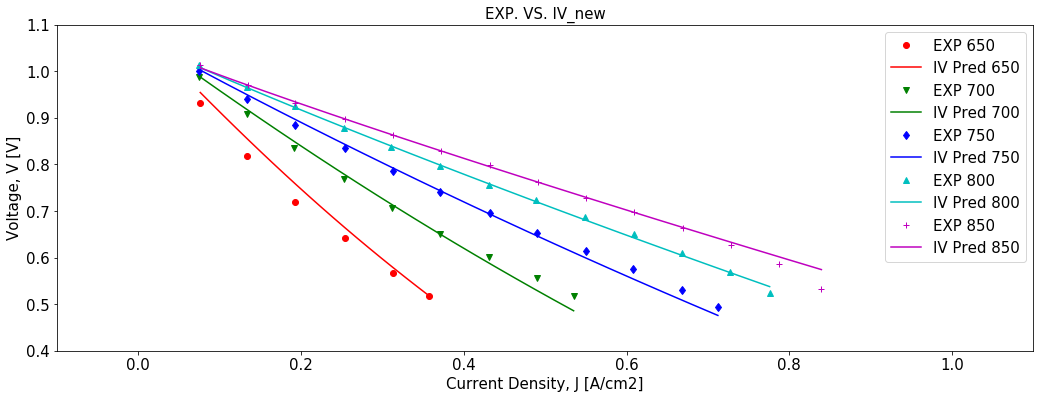

In [8]:
# comparison between JHM-2017 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.43236, 5639, 79616, 0.0, 0.0, 0.28, 0.28)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10

def objective_function_JM(param_guess):  
    filename = './Resources_More/ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(Toper[j]+273.15,Toper[j]+273.15,x[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_JM(param_guess)
bnds = ((None, None), (None, None), (None, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './Resources_More/ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

     fun: 0.01942475200926286
     jac: array([ 1.11753477e-02, -9.72067937e-07, -8.50763172e-07,  8.39315006e-03,
        3.96854378e-01, -1.16512994e-03, -3.08273127e-04])
 message: 'Optimization terminated successfully.'
    nfev: 150
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([ 2.69263711e-01,  5.63900022e+03,  7.96160001e+04, -5.98828589e-02,
        0.00000000e+00,  2.00000000e+00,  3.72783474e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

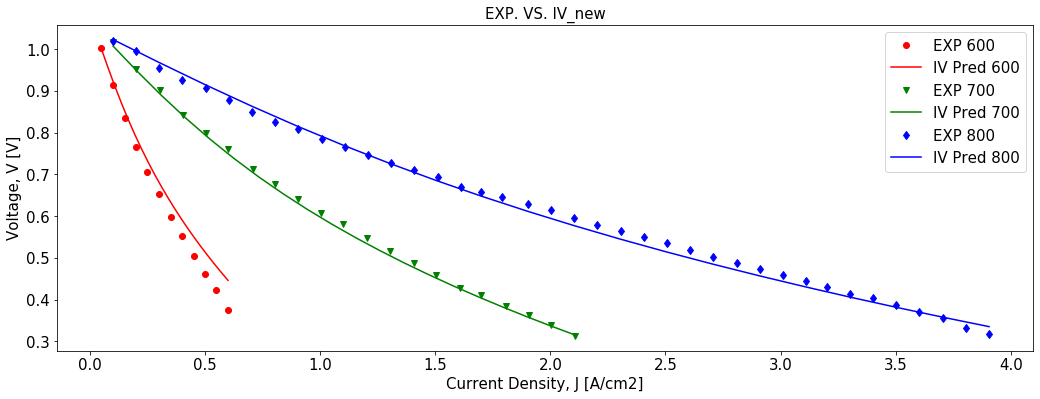

In [13]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.43236, 5639, 79616, 0.0, 0.0, 0.28, 0.28)
bnds = ((None, None), (None, None), (None, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8

def objective_function_BP(param_guess):  
    filename = './Resources_More/ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(Toper[j]+273.15,Toper[j]+273.15,x[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess)
result = minimize(objective_function_BP, param_guess, method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './Resources_More/ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

     fun: 0.04283768187477617
     jac: array([-3.65325715e-04,  3.27359885e-07, -2.17929482e-07, -2.53139064e-04,
        1.12462100e-02,  1.19468477e-02, -1.48317777e-05,  3.93791124e-05])
 message: 'Optimization terminated successfully.'
    nfev: 83
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 4.63411489e-01,  5.63900000e+03,  7.96160000e+04, -1.16713984e-01,
        0.00000000e+00,  2.00000000e-01,  2.80230937e-01,  9.99921048e+00])


Text(0.5, 1.0, 'EXP. VS. IV_new')

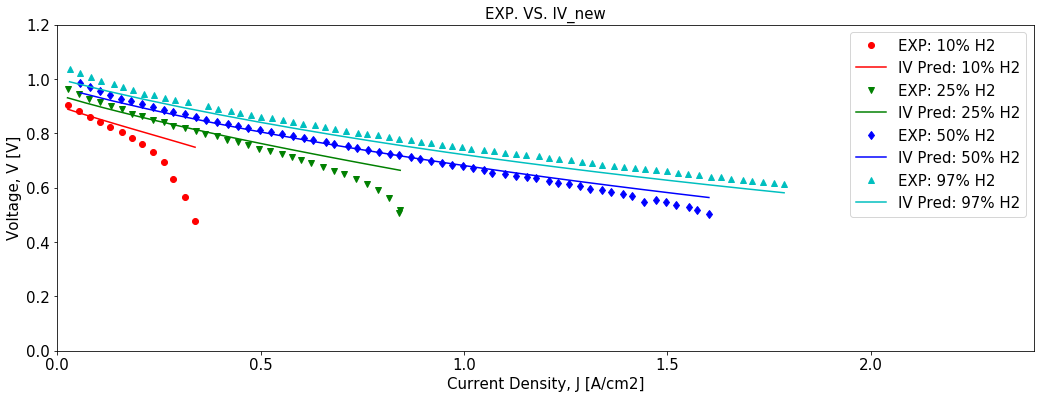

In [34]:
#comparison between Williford-2003 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.43236, 5639, 79616, 0.0, 0.0, 0.28, 0.28, 10.0)
bnds = ((None, None), (None, None), (None, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0), (5, 10))

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
Dsurf1=0.10805
Dsurf2=5.64088e-4
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Plist = [10, 25, 50, 97]

def objective_function_RW(param_guess):  
    filename = './Resources_More/ExperimentalData/RW2003/AllData_RW.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    pH2 = data[:, 4]/100
    pH2O = data[:, 5]/100

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2[j],pH2O[j], 0,0,0,1-pH2[j]-pH2O[j],pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           Dsurf1, Dsurf2, True, param_guess[5], 
                                                           param_guess[6],  param_guess[7])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_RW(param_guess)
result = minimize(objective_function_RW, param_guess, method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Plist)):
    oT_tmp = 750+273.15
    fT_tmp = oT_tmp
    pH2_tmp = Plist[i]/100
    pH2O_tmp = 0.03
    pN2_tmp = 1-pH2_tmp-pH2O_tmp
    
    # plot exp data
    filename = './Resources_More/ExperimentalData/RW2003/750_'+str(Plist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP: '+str(Plist[i])+'% H2')
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(oT_tmp,fT_tmp,Jlist[j],
                                                         pO2air,pN2air,pH2_tmp,pH2O_tmp,0,0,0,pN2_tmp,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         Dsurf1, Dsurf2, True, result.x[5], result.x[6],  result.x[7])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred: '+str(Plist[i])+'% H2')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlim(0, 2.4)
plt.ylim(0, 1.2)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

# Simulation results

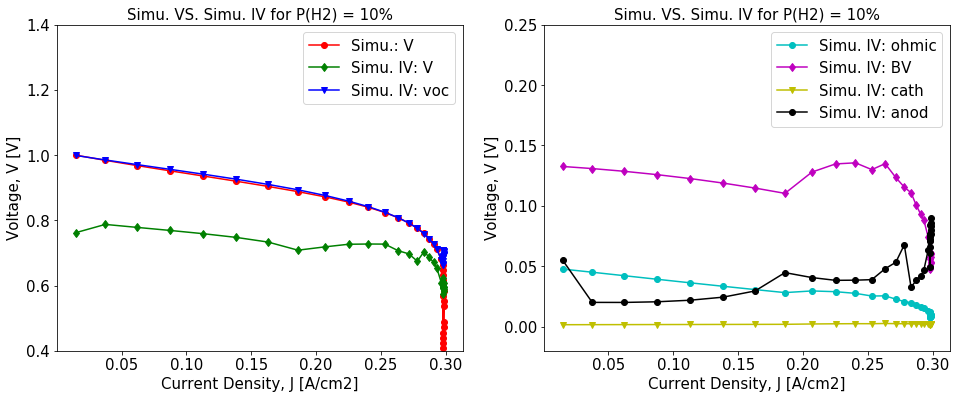

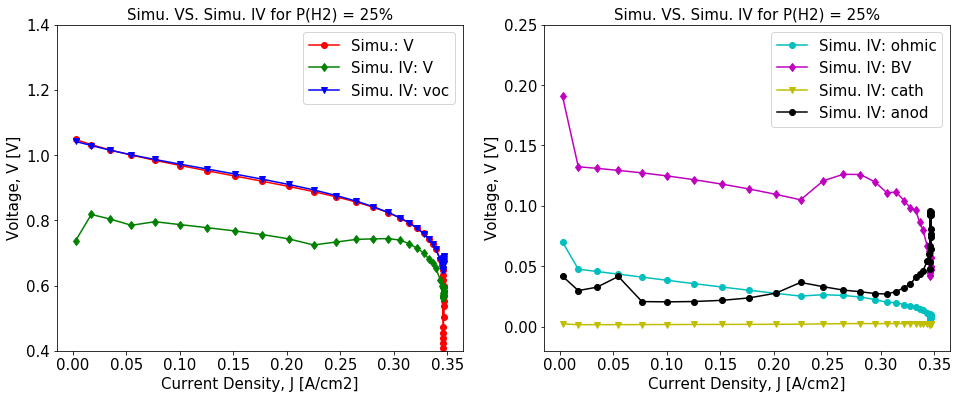

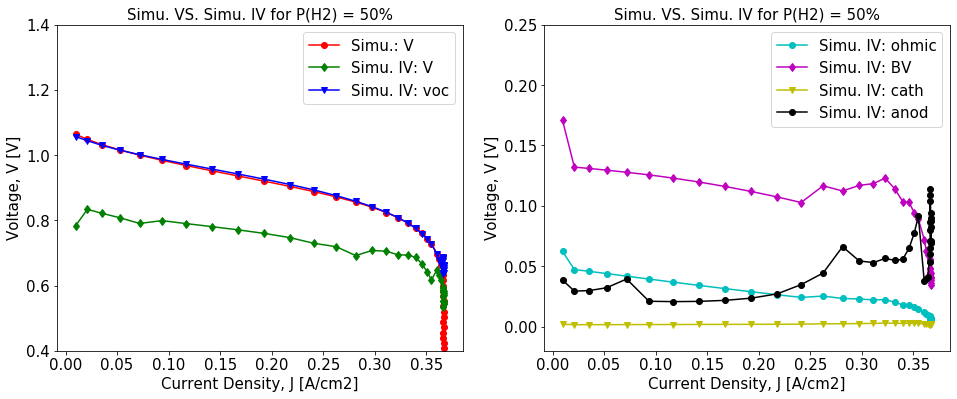

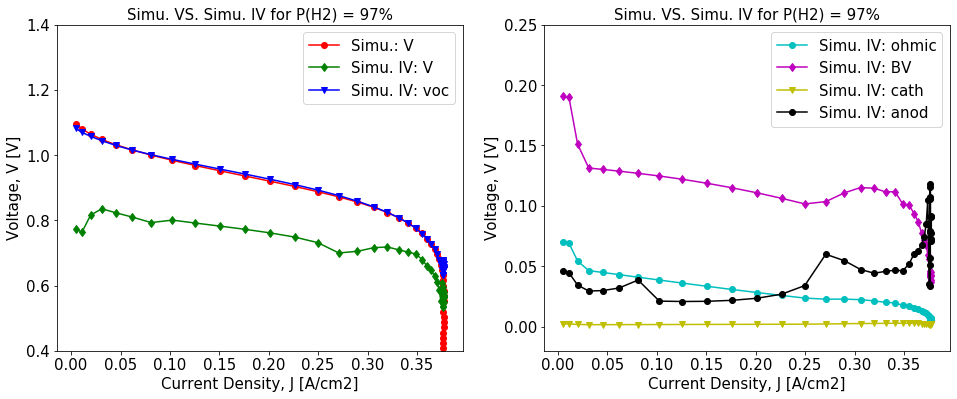

In [50]:
# compare simulation results with IV predictions during simulations

def file_read(FileName, withname = True):
    if withname == True:
        namearray = []
        valuearray = []
        with open(FileName) as f:
            i = 0
            for line in f.readlines():
                if i == 0:
                    namearray = line.strip().split()
                else:
                    linestr = line.strip().split()
                    linenum = [float(lineele) for lineele in linestr]
                    valuearray.append(linenum)
                i += 1
        return namearray, np.array(valuearray)
    else:
        valuearray = []
        with open(FileName) as f:
            for line in f.readlines():
                linestr = line.strip().split()
                if len(linestr)>0:
                    linenum = [float(lineele) for lineele in linestr]
                    valuearray.append(linenum)
        return np.array(valuearray)

Plist = [10, 25, 50, 97]

for i in range(len(Plist)):
    filename = './Resources_More/SimulationData/H2_'+str(Plist[i])+'/allResults.dat'
    name_tmp, res_simu = file_read(filename)
    
    filename = './Resources_More/SimulationData/H2_'+str(Plist[i])+'/voltages_all.txt'
    res_IV = file_read(filename, False)
    
    x = res_simu[:, 8]
    y = res_simu[:, 6]
    ind = x.argsort()
    xi = x[ind]
    yi = y[ind]
    I = res_IV[:,0]
    Ii = I[ind]
    v = res_IV[:, 1]
    vi = v[ind]
    voc = res_IV[:, 2]
    voci = voc[ind]
    ohmic = res_IV[:, 3]
    ohmici = ohmic[ind]
    BV = res_IV[:, 4]
    BVi = BV[ind]
    cath = -res_IV[:, 5]
    cathi = cath[ind]
    anod = -res_IV[:, 6]
    anodi = anod[ind]

    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    # plt.plot(xi, Ii, 'k^-', label = 'IV: current')
    plt.plot(xi, yi, 'ro-', label ='Simu.: V')
    plt.plot(xi, vi, 'gd-', label = 'Simu. IV: V')
    plt.plot(xi, voci, 'bv-', label = 'Simu. IV: voc')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best', fontsize=15)
    # ymin, ymax = plt.ylim()
    # plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
    plt.ylim(0.4, 1.4)
    plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
    plt.ylabel('Voltage, V [V]', fontsize = 15)
    plt.title('Simu. VS. Simu. IV for P(H2) = '+str(Plist[i])+'%', fontsize = 15)

    plt.subplot(1, 2, 2)
    plt.plot(xi, ohmici, 'co-', label = 'Simu. IV: ohmic')
    plt.plot(xi, BVi, 'md-', label = 'Simu. IV: BV')
    plt.plot(xi, cathi, 'yv-', label = 'Simu. IV: cath')
    plt.plot(xi, anodi, 'ko-', label = 'Simu. IV: anod')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best', fontsize=15)
    # ymin, ymax = plt.ylim()
    # plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
    plt.ylim(-0.02, 0.25)
    plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
    plt.ylabel('Voltage, V [V]', fontsize = 15)
    plt.title('Simu. VS. Simu. IV for P(H2) = '+str(Plist[i])+'%', fontsize = 15)

In [ ]:
# ?1: IV predicted V doesn't match simulated V, but the voc matches
# ?2: cath and anod is >0 ?

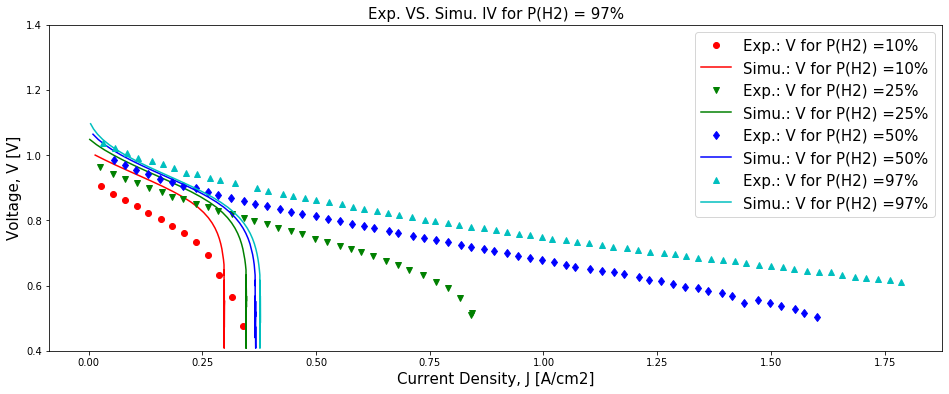

In [43]:
# compare simulation results with experimental results (RW2003)

def file_read(FileName, withname = True):
    if withname == True:
        namearray = []
        valuearray = []
        with open(FileName) as f:
            i = 0
            for line in f.readlines():
                if i == 0:
                    namearray = line.strip().split()
                else:
                    linestr = line.strip().split()
                    linenum = [float(lineele) for lineele in linestr]
                    valuearray.append(linenum)
                i += 1
        return namearray, np.array(valuearray)
    else:
        valuearray = []
        with open(FileName) as f:
            for line in f.readlines():
                linestr = line.strip().split()
                if len(linestr)>0:
                    linenum = [float(lineele) for lineele in linestr]
                    valuearray.append(linenum)
        return np.array(valuearray)

Plist = [10, 25, 50, 97]
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(16,6))
for i in range(len(Plist)):

    # plot exp data
    filename = './Resources_More/ExperimentalData/RW2003/750_'+str(Plist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'Exp.: V for P(H2) ='+str(Plist[i])+'%')
    
    # plot simu data
    filename = './Resources_More/SimulationData/H2_'+str(Plist[i])+'/allResults.dat'
    name_tmp, res_simu = file_read(filename)
    x = res_simu[:, 8]
    y = res_simu[:, 6]
    ind = x.argsort()
    xi = x[ind]
    yi = y[ind]
    plt.plot(xi, yi, colorlist[i]+'-', label = 'Simu.: V for P(H2) ='+str(Plist[i])+'%')
    
    plt.legend(loc='best', fontsize=15)
    # ymin, ymax = plt.ylim()
    # plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
    plt.ylim(0.4, 1.4)
    plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
    plt.ylabel('Voltage, V [V]', fontsize = 15)
    plt.title('Exp. VS. Simu. IV for P(H2) = '+str(Plist[i])+'%', fontsize = 15)

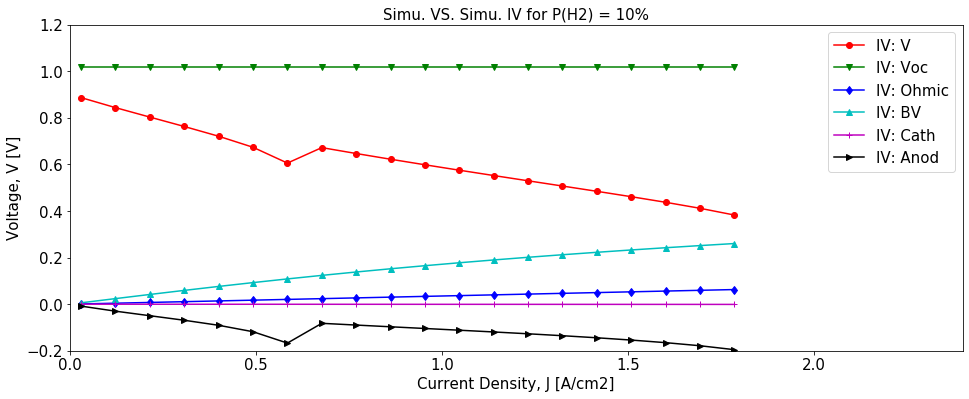

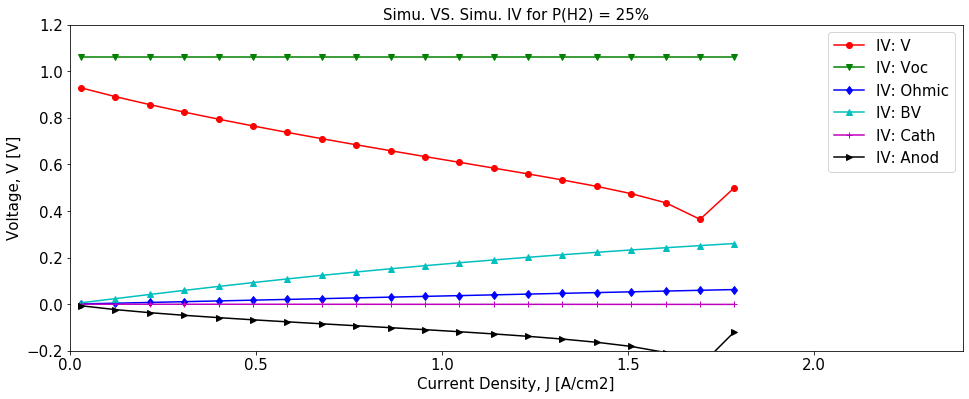

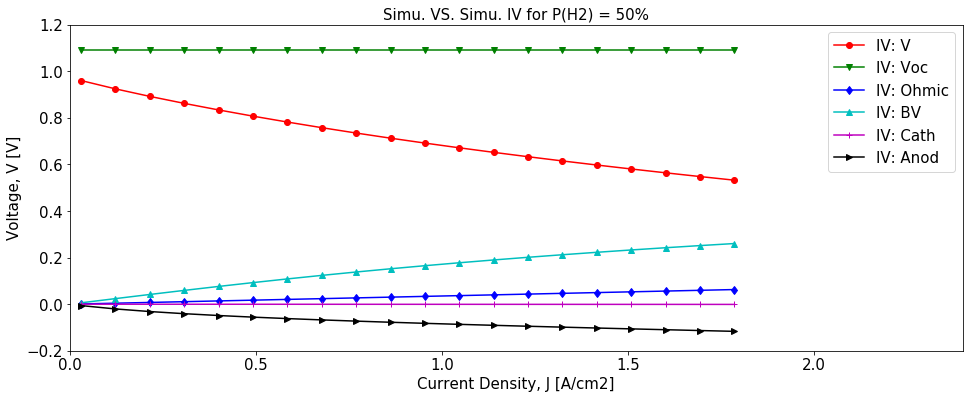

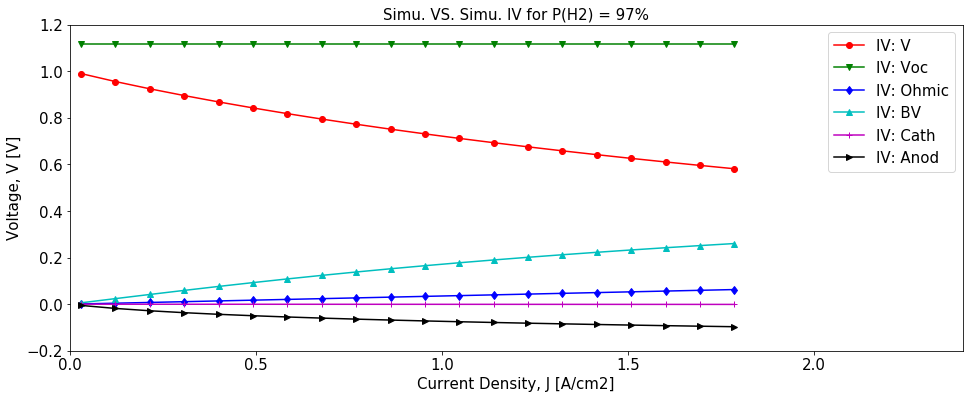

In [47]:
#comparison each components of IV predictions (according to fitted curve for RW2003)

#fitted curve
optimization = [0.4634, 5639, 79616, -0.1167, 0, 0.2, 0.2802, 10]
Dsurf1=0.10805
Dsurf2=5.64088e-4

Plist = [10, 25, 50, 97]

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+', '>']
colorlist = ['r', 'g', 'b', 'c', 'm', 'k']

for i in range(len(Plist)):
    oT_tmp = 750+273.15
    fT_tmp = oT_tmp
    pH2_tmp = Plist[i]/100
    pH2O_tmp = 0.03
    pN2_tmp = 1-pH2_tmp-pH2O_tmp
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    Voclist = np.zeros(20)
    Ohmiclist = np.zeros(20)
    BVlist = np.zeros(20)
    Cathlist = np.zeros(20)
    Anodlist = np.zeros(20)
    
    for j in range(20):
        Vlist[j], Voclist[j], Ohmiclist[j], BVlist[j], Cathlist[j], Anodlist[j] = IV_new_2(oT_tmp,fT_tmp,Jlist[j],
                                                         pO2air,pN2air,pH2_tmp,pH2O_tmp,0,0,0,pN2_tmp,pSys, 
                                                         optimization[0],optimization[1],optimization[2], 
                                                         optimization[3],optimization[4],Dsurf1, Dsurf2, 
                                                         True, optimization[5], optimization[6],optimization[7])
    
    # plot pred data
    plt.figure(figsize=(16,6))
    plt.plot(Jlist, Vlist, colorlist[0]+markerlist[0]+'-', label = 'IV: V')
    plt.plot(Jlist, Voclist, colorlist[1]+markerlist[1]+'-', label = 'IV: Voc')
    plt.plot(Jlist, Ohmiclist, colorlist[2]+markerlist[2]+'-', label = 'IV: Ohmic')
    plt.plot(Jlist, BVlist, colorlist[3]+markerlist[3]+'-', label = 'IV: BV')
    plt.plot(Jlist, Cathlist, colorlist[4]+markerlist[4]+'-', label = 'IV: Cath')
    plt.plot(Jlist, Anodlist, colorlist[5]+markerlist[5]+'-', label = 'IV: Anod')

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='upper right', fontsize=15)
    ymin, ymax = plt.ylim()
    # plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
    plt.xlim(0, 2.4)
    plt.ylim(-0.2, 1.2)
    plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
    plt.ylabel('Voltage, V [V]', fontsize = 15)
    plt.title('Simu. VS. Simu. IV for P(H2) = '+str(Plist[i])+'%', fontsize = 15)

# Degradation

In [44]:
def IV_DEG(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                   cT, BV_alpha,BV_prexp,BV_Eact,
                   SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14):
    
    # -- 10-26-2018. KP Recknagle. Includes coarsening, chrome poisoning, and IC scale growth degradation mechanisms.
    # -- 07-30-2018. JH Mason. added Chrome poisoning.
    # -- From B Koeppel
    # -- 2-26-2016 Version
    # -- Modified to include NETL (Hunter's) thermal coarsening degradation 3-08-2017.
    # -- Returned to Hunter for inclusion of Chrome poisoning degradation 07-30-2018.
    # -- when done incorp. into:  VoltageOnCurrent_Milestone2.2.3A.dat in SOFC/FY18/ compare_vocPoster2017_vocMilestone2.2.3A.dat
    # --
    # -------------------------------------------------------------------
    # --                                                               --
    # --       VoltageValueSV()                                          --
    # --                                                               --
    # --       V-I performance based on spreadsheet EC model           --
    # --       Updated to include SOA performance                      --
    # --                                                               --
    # -------------------------------------------------------------------
    # --
    # -- Available Local Inputs From SOFC-MP
    # --   oT                         Temperature oxidant (K)
    # --   fT                         Temperature fuel (K)
    # --   J                          Current density (A/cm2)
    # --   pO2air                     Air side partial pressure O2 (atm)
    # --   pN2air                     Air side partial pressure N2 (atm)
    # --   pH2                        Fuel side partial pressure H2 (atm)
    # --   pH2O                       Fuel side partial pressure H2O (atm)
    # --   pCO                        Fuel side partial pressure CO (atm)
    # --   pCO2                       Fuel side partial pressure CO2 (atm)
    # --   pCH4                       Fuel side partial pressure CH4 (atm)
    # --   pN2                        Fuel side partial pressure N2 (atm)
    # --   nActiveCell                Cell number
    # --   DistanceFromTheEdge        Distance along path (m)
    # --   DistanceFromTheEdgeRatio   Relative distance along the path 
    # -- SV1          state variable 1         (particle size of e-conduct in active anode)
    # -- SV2          state variable 2         (particle size of ion-conduct in active anode)
    # -- SV3          state variable 3         (pore size in active anode)
    # -- SV4          state variable 4         (TPB length in active anode)
    # -- SV5          state variable 5         (tortuosity of e-conduct in active anode)
    # -- SV6          state variable 6         (tortuosity of ion-conduct in active anode)
    # -- SV7          state variable 7         (tortuosity of pore in active anode)
    # -- SV8          state variable 8         (
    # -- SV9          state variable 9         (
    # -- SV10         state variable 10        (
    # -- SV11         state variable 11        (
    # --
    # -- Required Subroutine Outputs
    # --   Z                          Voltage (V)
    # --
    # ------------------------------------------------------------------
    # --
    # -- User-Assigned Geometry/Material Inputs
    # --   th_a       Thickness anode (microns)
    # --   th_e       Thickness electrolyte (microns)
    # --   th_c       Thickness cathode (microns)
    # --   th_ic      Thickness interconnect (microns)
    # --   por_a      Porosity anode (%)
    # --   por_c      Porosity cathode (%)
    # --   tort_a     Tortuosity anode
    # --   tort_c     Tortuosity cathode
    # --   BV_alpha   Butler-Volmer 'alpha' constant
    # --   BV_prexp   Butler-Volmer pre-exponential constant
    # --   BV_Eact    Butler-Volmer activation energy
    # --   R_cont     Contact resistance
    # --
    # -- User-Assigned Constants/Conversions
    # --   R          Ideal gas constant
    # --   F          Faraday's constant
    # --   atm2Pa     Conversion for pressure atm -> Pa
    # --   mic2m      Conversion for length micron -> m
    # ------------------------------------------------------------------
    # --

    # -- UPDATE - - Testing and comparing old and new models for PNNL code
    # -- - Dr. Jerry Hunter Mason (JHM) at NETL beginning Dec 2016
    # --
    # -- Added new microstructural properties not used previously Dec 2016
    # -- Added new versions of conductivity calculations based on some of these properties Dec 2016
    # -- Added triple phase boundary density to Butler-Volmer calculations Jan 2017
    # -- Added Knudsen diffusion to diffusion calculations Jan 2017

    # function VoltageValueSV(sv_in)
    # -- Initial Values placed here before integration with SOFC-MP
    # local SV_out = {numfields=1}
    # for k,v in pairs(sv_in) do
    #    SV_out.numfields = SV_out.numfields + 1
    #    SV_out[tostring(k)] = v
    # end
    
    
    # oT=SV_out["oT"]
    # fT=SV_out["fT"]
    # cT=SV_out["cT"]
    # J=SV_out["J"]
    # --nActiveCell=SV_out["nActiveCell"]
    # --DistanceFromTheEdge=SV_out["DistanceFromTheEdge"]
    # --DistanceFromTheEdgeRatio=SV_out["DistanceFromTheEdgeRatio"]
    # pH2=SV_out["pH2"]
    # pH2O=SV_out["pH2O"]
    # pCO=SV_out["pCO"]
    # pCO2=SV_out["pCO2"]
    # pCH4=SV_out["pCH4"]
    # pN2=SV_out["pN2"]
    # pO2air=SV_out["pO2air"]
    # pN2air=SV_out["pN2air"]
    # SV1=SV_out["SV1"]
    # SV2=SV_out["SV2"]
    # SV3=SV_out["SV3"]
    # SV4=SV_out["SV4"]
    # SV5=SV_out["SV5"]
    # SV6=SV_out["SV6"]
    # SV7=SV_out["SV7"]
    # SV8=SV_out["SV8"]
    # SV9=SV_out["SV9"]
    # SV10=SV_out["SV10"]
    # SV11=SV_out["SV11"]
    # SV12=SV_out["SV12"]
    # SV13=SV_out["SV13"]
    # SV14=SV_out["SV14"]
    # --
    # -- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    Ptotc=pO2air+pN2air
    # --
    # -- reasonble initial values
    # --SV1= 6.1e-7
    # --SV2= 4.75e-7
    # --SV3= 2.00e-6
    # --SV4= 7.00e+8
    # --SV5= 2.05
    # --SV6= 2.5
    # --SV7= 2.5
    # --SV8= 0.0
    # --SV9= 0.0
    # --SV10= 0.0
    # --SV11= 0.0
    # ----others zero
    BVflag=1        #-- 0=old method, 1=pressurized method
    # -- Added logic for choosing degradation modes
    coarse_flag = 1 #-- value of 1 includes electrode coarsening model
    chrome_flag = 1 #-- value of 1 includes chromium poisoning model
    scale_flag =  0 #-- value of 1 included IC scale growth

    printflag=0
    # if printflag==1:
    #     checkfile1=io.open("00checkSV1.txt","a")
    #     checkfile1:write("In VOC.dat SV1 (d_eaa)= ",SV1,"\n")
    #     checkfile1:write("In VOC.dat SV2 (d_iaa)= ",SV2,"\n")
    #     --checkfile1:write("In VOC.dat SV3 (d_paa)= ",SV3,"\n")
    #     --checkfile1:write("In VOC.dat SV4 (ltpba)= ",SV4,"\n")
    #     --checkfile1:write("In VOC.dat SV5 (tortea)= ",SV5,"\n")
    #     --checkfile1:write("In VOC.dat SV6 (tortia)= ",SV6,"\n")
    #     --checkfile1:write("In VOC.dat SV7 (tortpa)= ",SV7,"\n")
    #     --checkfile1:write("In VOC.dat SV8 (d_eac)= ",SV8,"\n")
    #     --checkfile1:write("In VOC.dat SV9 (d_iac)= ",SV9,"\n")
    #     --checkfile1:write("In VOC.dat SV10(d_pac)= ",SV10,"\n")
    #     --checkfile1:write("In VOC.dat SV11(ltpbc)= ",SV11,"\n")
    #     ----add other SVs here
    #     checkfile1:close()

    if chrome_flag == 1:
        pH2Oair=0.01
        # --print(pH2Oair,pO2air)
        pCrO2OH2air= SV9
        Ptotc=pO2air+pN2air+pH2Oair+pCrO2OH2air # -- Moved here by KPR 10/18
        # --print(pCrO2OH2air,Ptotc)

    # -- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    # --tort_a=         2.5
    # --tort_c=         2.5
    tort_a=         SV7
    tort_c=         SV7

    # -- Additional microstructural properties added by JHM Dec 2016
    # -- th_aa 	um Anode active layer thickness
    # -- th_ca 	um Cathode active layer thickness
    # -- V_ic 	Vol % ionic conductor in cathode (active layer)
    # -- V_ia 	Vol % ionic conductor in anode (active layer)
    # -- V_eca 	Vol % electr conductor in cathode active layer
    # -- V_eaa	Vol % electr conductor in anode active layer
    # -- V_ec		Vol % of electronic conductor in cathode support
    # -- V_ea		Vol % of electronic conductor in anode support
    # -- tort_ae	Tort of electronic conducting phase in anode
    # -- tort_ce	Tort of electronic conducting phase in cathode
    # -- L_tpb_c	cm/cm^3 Triple phase boundary density in cathode
    # -- L_tpb_a	cm/cm^3 Triple phase boundary density in anode
    # --
    # -- Additional microstructural properties added by KPR Feb 2017
    # -- d_eaa	um diameter of electr cond particles in act anode
    # -- d_iaa	um diameter of ion cond particles in act anode
    # -- d_eac	um diameter of electr cond particles in act cathode
    # -- d_iac	um diameter of ion cond particles in act cathode
    
    th_aa =         30.0
    th_ca =         30.0
    if th_ca>th_c:
        th_ca = th_c

    V_ic =          26.0	# --See volfs in EvolutionSV()
    V_ia =          26.0
    V_eca =         100.0-por_c-V_ic
    V_eaa =         100.0-por_a-V_ia
    V_ec =          100.0-por_c
    V_ea =          100.0-por_a
    # --tort_ae =       2.05
    # --tort_ce =       1.21
    # --L_tpb_c =       7.0e8
    # --L_tpb_a =       7.0e8
    L_tpb_cz=       7.0e8
    L_tpb_az=       7.0e8
    tort_ae =       SV5
    tort_ce =       SV5
    L_tpb_c =       SV4		# --Uses , (via SV1, SV2)
    if chrome_flag == 1:
        L_tpb_c =       SV4*(1.0-SV8)	# --coverage Theta

    # -- JHM 8/18 added SV8 (coverage of TPB by Cr2O3)
    L_tpb_a =  SV4		# --Uses SV1, SV2
    L_tpb_mean = 2.0/(1.0/L_tpb_c + 1.0/L_tpb_a)
    L_tpbz_mean = 2.0/(1.0/L_tpb_cz + 1.0/L_tpb_az)		# ---KPR fix for BVflag=0. Apr5,2017

    # -- Additional microstructural properties added by JHM January 2017
    # -- tort_ai		Tortuosity of ionic conductor in active layer of anode
    # -- tort_ci		Tortuosity of ionic conductor in active layer of cathode
    # -- r_pore_a		cm Average pore radius in anode
    # -- r_pore_c		cm Averyage pore radius in cathode
    # --tort_ai =       2.5
    # --tort_ci =       2.5
    tort_ai =       SV6
    tort_ci =       SV6
    # --r_pore_a =      1.0e-4
    # --r_pore_c =      1.0e-4
    r_pore_a =      SV3/2.0*100.
    r_pore_c =      SV3/2.0*100.

    # BV_alpha=       0.43236
    # BV_prexp=       5639.0
    # BV_Eact=        79616.0
    BV_alpha2a=     2.0
    BV_prexp2a=     465000.0  #--old
    BV_Eact2a=      125000.0
    BV_gamma2a=     0.5
    BV_alpha2f=     1.0    #--old
    BV_prexp2f=     75000000.0
    BV_Eact2f=      110000.0    #--old
    BV_gamma2f=     0.133
    # --
    # --
    # --BV0
    BV_alpha=       0.43236
    BV_prexp=       5639.0
    BV_Eact=        79616.0
    # --BV1
    BV_gamma2f=     0.133
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    # --
    BV_gamma2a=     0.5
    BV_alpha2a=     0.44
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    # --
    # --
    R_cont=         0.0
    V_loss=         0.0


    # -- Additional microstructural BV terms added by JHM Dec 2016
    # -- scaled to account for Triple Phase Boundary density
    BV_prexp_TPB = BV_prexp/(L_tpbz_mean)  # --KPR BV0 fix. Apr5,2017
    BV_prexp2a_TPB = BV_prexp2a/L_tpb_cz
    BV_prexp2f_TPB = BV_prexp2f/L_tpb_az

    # --
    # -- Compute the local cell temperature
    # ------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    # --
    # -- Compute the Nernst open circuit voltage
    # ------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    # --
    # -- Compute the ohmic polarization
    # ------------------------------------------------------------------
    # -- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    # -- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    # -- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117

    # -- Old: s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    # ----------- New JHM Dec 2016:
    s_c_act = (s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*V_eca/tort_ce*0.01
    s_c = (s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*V_ec/tort_c*0.01

    # -- Compute the anode conductivity
    s_aA=1000

    # -- Old: s_a=s_aA*(1.0-(0.018*por_a))
    # ----------- New JHM Dec 2016:
    s_a_act = s_aA*V_eaa/tort_ae*0.01
    s_a = s_aA*V_ea/tort_a*0.01

    # -- Compute the effective cell resistivity
    # -- Updated by JHM January 2017
    Ra = (th_a-th_aa)/s_a + th_aa/s_a_act
    Rc = (th_c-th_ca)/s_c + th_ca/s_c_act
    Re = th_e/s_e
    Rint = th_ic/s_ic
    Ri = R_cont + (Ra + Rc + Re + Rint)*0.0001
    # -- Compute the transient scale ohmic loss
    if scale_flag == 1:
        Rcont=SV12
        # -- Compute the total ohmic loss
        Ohmic=Ri*J+Rcont*J
        if printflag==1:
            print("   Ohmic      = ",Ohmic)
    else:
        Ohmic=Ri*J
    # --
    # -- Compute the activation polarization (old method or new pressurized method)
    # ------------------------------------------------------------------
    if BVflag==0:
        # -- Old method
        # ---------- No TPB:
        # -- i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        # ---------- With TPB JHM Dec 2016:
        i0 = BV_prexp_TPB*L_tpb_mean*math.exp(-BV_Eact/R/Tk)
        BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1))
    else:
        # -- New method
        # ---------- Without TPB considered
        # -- ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode^BV_gamma2f
        # -- ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air^BV_gamma2a
        # ---------- With TPB considered JHM Dec 2016
        ioeff_f=BV_prexp2f_TPB*L_tpb_a*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a_TPB*L_tpb_c*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a

        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    # if printflag==1:
    # --print(BV_prexp2f_TPB, L_tpb_a, BV_Eact2f, pO2anode, BV_gamma2f)
    # --print(R, Tk, BV_alpha2f, J, ioeff_f, F, eta_f, eta_a)
    # --print(BV)

    # --
    # -- Compute the diffusion coefficients
    # ------------------------------------------------------------------
    # -- Make 0.0 species non-zero to make equations defined
    if pCO<=0:
        pCOc=1e-16
    else:
        pCOc=pCO

    if pCO2<=0:
        pCO2c=1e-16
    else:
        pCO2c=pCO2

    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    
    # -- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0
    H2Oii=18.0
    COii=28.0
    CO2ii=44.0
    N2ii=28.0
    O2ii=32.0
    CH4ii=16.0
    CrO2OH2ii = 102.0 # -- Molecular weight of CrO2(OH)2
    
    # -- Average molecular weight & alphas
    Mavea=H2_mf*H2ii+H2O_mf*H2Oii+CO_mf*COii+CO2_mf*CO2ii+N2_mf*N2ii+CH4_mf*CH4ii
    alH2=1-math.sqrt(H2ii/Mavea)
    alH2O=1-math.sqrt(H2Oii/Mavea)
    alCO=1-math.sqrt(COii/Mavea)
    alCO2=1-math.sqrt(CO2ii/Mavea)
    alN2=1-math.sqrt(N2ii/Mavea)
    alCH4=1-math.sqrt(CH4ii/Mavea)
    # -- get alphas for cathode side
    # -- Ptotc=pO2air+pN2air --Moved by JHM 8/18
    pO2air_mf = pO2air/Ptotc
    pN2air_mf = pN2air/Ptotc
    Mavec = pO2air_mf*O2ii+pN2air_mf*N2ii
    alO2air=1-math.sqrt(O2ii/Mavec) # -- JHM 8/18 fixed typo (was using Mavea previously)
    alN2air=1-math.sqrt(N2ii/Mavec) # -- JHM 8/18 fixed typo (was using Mavea previously)
    
    if chrome_flag == 1:
        pH2Oair_mf = pH2Oair/Ptotc # -- JHM 8/18 added for Cr poisoning
        pCrO2OH2air_mf = pCrO2OH2air/Ptotc # -- JHM 8/18 added for Cr poisoning
        Mavec = pO2air_mf*O2ii+pN2air_mf*N2ii+pH2Oair_mf*H2Oii+pCrO2OH2air_mf*CrO2OH2ii
        alO2air=1-math.sqrt(O2ii/Mavec) # -- JHM 8/18 fixed typo (was using Mavea previously)
        alN2air=1-math.sqrt(N2ii/Mavec) # -- JHM 8/18 fixed typo (was using Mavea previously)
        alH2Oair=1-math.sqrt(H2Oii/Mavec) # -- JHM 8/18 added for Cr poisoning
        alCrO2OH2air=1-math.sqrt(CrO2OH2ii/Mavec) # -- JHM 8/18 added for Cr poisoning

    # -- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    
    # -- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    
    # -- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    # --checkfile1:write("In VOC.dat D_H2 = ",D_H2,"\n")
    # --
    # -- Compute the cathode concentration polarization
    # ------------------------------------------------------------------
    # -- Old Model
    Deffc=0.01*por_c*O2N2/tort_c
    # --checkfile1:write("In VOC.dat DeffcOLD = ",Deffc,"\n")
    # -- New Model - Add Knudsen Diffusion and Pore Radius - JHM January 2016
    convf = 1.0e7
    # -- Calculate Knudsen Diffusion
    Dk_O2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*O2ii))**0.5*r_pore_c
    # --    Deffc = 0.01*por_c/tort_c*(2.0/(1.0/O2N2+1.0/Dk_O2))
    # --    Deffc = 0.01*por_c/tort_c*(1.0/(1.0/O2N2+1.0/Dk_O2))  --remove factor of 2. KPR. Apr5,2017
    # --io.write("Deffc,1= ",Deffc,"\n")
    Deffc = 0.01*por_c/(tort_c**1)*(1.0/((1.0-alO2air*pO2air_mf)/O2N2+1.0/Dk_O2))
    # --io.write("Deffc,1= ",Deffc,"\n")
    # --checkfile1:write("In VOC.dat Dk_O2 = ",Dk_O2,"\n")
    # --checkfile1:write("In VOC.dat Deffc = ",Deffc,"\n")
    # --
    if chrome_flag == 1:
        # -------- Update - Add steam and chromium species to model - JHM 8/18 --------
        # -- - Note: using Chapman-Enskog method with parameters from:
        # -- Yakabe, H., et al., J. Power Sources, 86, 423-431 (2000)
        # -- Young, D.J., and Pint, B.A., Oxidation of Metals, 66(3/4), 137-153 (2006)
        # -- Collision diamters (Angstroms)
        sigma_O2 = 3.467
        sigma_N2 = 3.798
        sigma_H2O = 2.641
        sigma_CrO2OH2 = 4.5 # -- uncertainty range from 4 to 5 Young and Pint (2006)
        # -- Characteristic energies of reaction divided by boltzman's constant (unitless)
        epsik_O2 = 106.7
        epsik_N2 = 71.4
        epsik_H2O = 809.1
        epsik_CrO2OH2 = 340.0 # -- uncertainty range from 230 to 450 Young and Pint (2006)
        # -- - Note: uncertainty ranges for CrO2OH2 parameters result in +/- 15% uncertainty for diffusivity of CrO2OH2
        # -- Calculate Knudsen Diffusion

        Dk_O2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*O2ii))**0.5*r_pore_c
        Dk_N2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*N2ii))**0.5*r_pore_c
        Dk_H2O = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*H2Oii))**0.5*r_pore_c
        Dk_CrO2OH2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*CrO2OH2ii))**0.5*r_pore_c

        sigma_O2N2 = (sigma_O2+sigma_N2)/2.0
        sigma_O2H2O = (sigma_O2+sigma_H2O)/2.0
        sigma_O2CrO2OH2 = (sigma_O2+sigma_CrO2OH2)/2.0
        sigma_N2H2O = (sigma_N2+sigma_H2O)/2.0
        sigma_N2CrO2OH2 = (sigma_N2+sigma_CrO2OH2)/2.0
        sigma_H2OCrO2OH2 = (sigma_H2O+sigma_CrO2OH2)/2.0

        epsik_O2N2 = (epsik_O2*epsik_N2)**0.5
        epsik_O2H2O = (epsik_O2*epsik_H2O)**0.5
        epsik_O2CrO2OH2 = (epsik_O2*epsik_CrO2OH2)**0.5
        epsik_N2H2O = (epsik_N2*epsik_H2O)**0.5
        epsik_N2CrO2OH2 = (epsik_N2*epsik_CrO2OH2)**0.5
        epsik_H2OCrO2OH2 = (epsik_H2O*epsik_CrO2OH2)**0.5

        Tn_O2N2 = cT/epsik_O2N2
        Tn_O2H2O = cT/epsik_O2H2O
        Tn_O2CrO2OH2 = cT/epsik_O2CrO2OH2
        Tn_N2H2O = cT/epsik_N2H2O
        Tn_N2CrO2OH2 = cT/epsik_N2CrO2OH2
        Tn_H2OCrO2OH2 = cT/epsik_H2OCrO2OH2

        Dbi_A=1.06036
        Dbi_B=0.15610
        Dbi_C=0.19300
        Dbi_D=0.47635
        Dbi_E=1.03587
        Dbi_F=1.52996
        Dbi_G=1.76474
        Dbi_H=3.89411

        Omega_O2N2 = (Dbi_A/Tn_O2N2**Dbi_B)+(Dbi_C/math.exp(Dbi_D*Tn_O2N2))
        +(Dbi_E/math.exp(Dbi_F*Tn_O2N2))+(Dbi_G/math.exp(Dbi_H*Tn_O2N2))
        Omega_O2H2O = (Dbi_A/Tn_O2H2O**Dbi_B)+(Dbi_C/math.exp(Dbi_D*Tn_O2H2O))
        +(Dbi_E/math.exp(Dbi_F*Tn_O2H2O))+(Dbi_G/math.exp(Dbi_H*Tn_O2H2O))
        Omega_O2CrO2OH2 = (Dbi_A/Tn_O2CrO2OH2**Dbi_B)+(Dbi_C/math.exp(Dbi_D*Tn_O2CrO2OH2))
        +(Dbi_E/math.exp(Dbi_F*Tn_O2CrO2OH2))+(Dbi_G/math.exp(Dbi_H*Tn_O2CrO2OH2))
        Omega_N2H2O = (Dbi_A/Tn_N2H2O**Dbi_B)+(Dbi_C/math.exp(Dbi_D*Tn_N2H2O))
        +(Dbi_E/math.exp(Dbi_F*Tn_N2H2O))+(Dbi_G/math.exp(Dbi_H*Tn_N2H2O))
        Omega_N2CrO2OH2 = (Dbi_A/Tn_N2CrO2OH2**Dbi_B)+(Dbi_C/math.exp(Dbi_D*Tn_N2CrO2OH2))
        +(Dbi_E/math.exp(Dbi_F*Tn_N2CrO2OH2))+(Dbi_G/math.exp(Dbi_H*Tn_N2CrO2OH2))
        Omega_H2OCrO2OH2 = (Dbi_A/Tn_H2OCrO2OH2**Dbi_B)+(Dbi_C/math.exp(Dbi_D*Tn_H2OCrO2OH2))
        +(Dbi_E/math.exp(Dbi_F*Tn_H2OCrO2OH2))+(Dbi_G/math.exp(Dbi_H*Tn_H2OCrO2OH2))

        Dc_O2N2 =(0.001858)*(((cT**3.0)*(O2ii+N2ii)/(O2ii*N2ii))**0.5)/(Ptotc*(sigma_O2N2**2.0)*Omega_O2N2)
        Dc_O2H2O =(0.001858)*(((cT**3.0)*(O2ii+H2Oii)/(O2ii*H2Oii))**0.5)/(Ptotc*(sigma_O2H2O**2.0)*Omega_O2H2O)
        Dc_O2CrO2OH2 =(0.001858)*(((cT**3.0)*(O2ii+CrO2OH2ii)/(O2ii*CrO2OH2ii))**0.5)/(Ptotc*(sigma_O2CrO2OH2**2.0)*Omega_O2CrO2OH2)
        Dc_N2H2O =(0.001858)*(((cT**3.0)*(H2Oii+N2ii)/(H2Oii*N2ii))**0.5)/(Ptotc*(sigma_N2H2O**2.0)*Omega_N2H2O)
        Dc_N2CrO2OH2 =(0.001858)*(((cT**3.0)*(CrO2OH2ii+N2ii)/(CrO2OH2ii*N2ii))**0.5) /(Ptotc*(sigma_N2CrO2OH2**2.0)*Omega_N2CrO2OH2)
        Dc_H2OCrO2OH2 =(0.001858)*(((cT**3.0)*(CrO2OH2ii+H2Oii)/(CrO2OH2ii*H2Oii))**0.5)/(Ptotc*(sigma_H2OCrO2OH2**2.0)*Omega_H2OCrO2OH2)

        sum_O2 = pN2air_mf/Dc_O2N2+pH2Oair_mf/Dc_O2H2O+pCrO2OH2air_mf/Dc_O2CrO2OH2
        sum_N2 = pO2air_mf/Dc_O2N2+pH2Oair_mf/Dc_N2H2O+pCrO2OH2air_mf/Dc_N2CrO2OH2
        sum_H2O = pO2air_mf/Dc_O2H2O+pN2air_mf/Dc_N2H2O+pCrO2OH2air_mf/Dc_H2OCrO2OH2
        sum_CrO2OH2 = pO2air_mf/Dc_O2CrO2OH2+pN2air_mf/Dc_N2CrO2OH2+pH2Oair_mf/Dc_H2OCrO2OH2

        Dm_O2 = (1.0-pO2air_mf)/sum_O2
        Dm_N2 = (1.0-pN2air_mf)/sum_N2
        Dm_H2O = (1.0-pH2Oair_mf)/sum_H2O
        Dm_CrO2OH2 = (1.0-pCrO2OH2air_mf)/sum_CrO2OH2


        Deff_O2 = 0.01*por_c/(tort_c**1)*(1.0/((1.0-alO2air*pO2air_mf)/Dm_O2+1.0/Dk_O2))
        # --    Deff_N2 = 0.01*por_c/(tort_c**1)*(1.0/((1.0-alN2air*pN2air_mf)/Dm_N2+1.0/Dk_N2));
        # --    Deff_H2O = 0.01*por_c/(tort_c**1)*(1.0/((1.0-alH2Oair*pH2Oair_mf)/Dm_H2O+1.0/Dk_H2O));
        Deff_CrO2OH2 = 0.01*por_c/(tort_c**1)*(1.0/((1.0-alCrO2OH2air*pCrO2OH2air_mf)/Dm_CrO2OH2+1.0/Dk_CrO2OH2))
        z_Deff_Cr = (100*th_c*mic2m)**2/Deff_CrO2OH2 # -- To calculate gradient of CrO2OH2 in cathode
        Deffc = Deff_O2
        Cr_Flux = SV10*th_c*1e-4/F # -- To calculate loss of CrO2OH2 from air flow in channel
        # -----------------------------
        # --M_dot_air = 0.0  --//// used to estimate sink term for pCrO2OH2air ////
        # --pCrO2OH2air = pCrO2OH2air + Cr_Flux/M_dot_air*W*dx -- Estimate decrease in chromium concentration in air channel
        # -----------------------------
        # --if printflag==1 then
        # --  io.write("In VOC.dat z_Deff_Cr= ",z_Deff_Cr,"\n")
        # --end --print
        # --  print(th_c,F,z_Deff_Cr,SV10,Cr_Flux)
        # --  print(OxidantFlowRate,nCells)

    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    # --
    # -- Compute the anode concentration polarization
    # ------------------------------------------------------------------
    # -- Old Model
    # --DeffH2_old=D_H2
    # --DeffH2O_old=0.01*H2O_UD*por_a/tort_a
    # --DeffCO_old=0.01*CO_UD*por_a/tort_a
    # --DeffCO2_old=0.01*CO2_UD*por_a/tort_a
    # --print(DeffH2_old, DeffH2O_old, DeffCO_old, DeffCO2_old)
    # -- New Model - Add Knudsen Diffusion and Pore Radius - JHM January 2016
    # -- Calculate Knudsen Diffusion for each species
    Dk_H2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*H2ii))**0.5*r_pore_a
    Dk_H2O = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*H2Oii))**0.5*r_pore_a
    Dk_CO = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*COii))**0.5*r_pore_a
    Dk_CO2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*CO2ii))**0.5*r_pore_a
    # --    DeffH2 = 2.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a*Dk_H2))
    # --    DeffH2O = 0.01*por_a/tort_a*(2.0/(1.0/H2O_UD+1.0/Dk_H2O))
    # --    DeffCO = 0.01*por_a/tort_a*(2.0/(1.0/CO_UD+1.0/Dk_CO))
    # --    DeffCO2 = 0.01*por_a/tort_a*(2.0/(1.0/CO2_UD+1.0/Dk_CO2))
    # --    DeffH2 = 1.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a*Dk_H2))  --** Removed factor of 2 from Deff
    # --    DeffH2O = 0.01*por_a/tort_a*(1.0/(1.0/H2O_UD+1.0/Dk_H2O))  --** Removed factor of 2 from Deff
    # --    DeffCO = 0.01*por_a/tort_a*(1.0/(1.0/CO_UD+1.0/Dk_CO))  --** Removed factor of 2 from Deff
    # --    DeffCO2 = 0.01*por_a/tort_a*(1.0/(1.0/CO2_UD+1.0/Dk_CO2))  --** Removed factor of 2 from Deff
    # --print(DeffH2, DeffH2O, DeffCO, DeffCO2)
    # --
    DeffH2 = 1.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a**1*Dk_H2))
    DeffH2O = 0.01*por_a/tort_a**1*(1.0/((1.0-alH2O*H2O_mf)/H2O_UD+1.0/Dk_H2O))
    DeffCO = 0.01*por_a/tort_a**1*(1.0/((1.0-alCO*CO_mf)/CO_UD+1.0/Dk_CO))
    DeffCO2 = 0.01*por_a/tort_a**1*(1.0/((1.0-alCO2*CO2_mf)/CO2_UD+1.0/Dk_CO2))
    # --checkfile1:write("In VOC.dat Dk_H2 = ",Dk_H2,"\n")
    # --checkfile1:write("In VOC.dat Dk_H2O = ",Dk_H2O,"\n")
    # --checkfile1:write("In VOC.dat DeffH2 = ",DeffH2,"\n")
    # --checkfile1:write("In VOC.dat DeffH2O = ",DeffH2O,"\n")

    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    # -- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim):
        Z=1/0
    else:
        Jcalc=J
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA1=OPa_A
        holdB1=OPa_B
        holdC1=OPa_C
        stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
        stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
        if stabcheck>0:
            if stabcheck2>0:
                Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
                holdA2=0
                holdB2=0
                holdC2=0
                goober=1
            else:
                DeffH2=0.01*H2_UD*por_a/tort_a
                DeffH2O=0.01*H2O_UD*por_a/tort_a
                DeffCO=0.01*CO_UD*por_a/tort_a
                DeffCO2=0.01*CO2_UD*por_a/tort_a
                alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
                blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
                clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
                dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
                OPa_A=(Jcalc+blim+dlim)/blim/dlim
                OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
                OPa_C=(Jcalc-alim-clim)/alim/clim
                holdA2=OPa_A
                holdB2=OPa_B
                holdC2=OPa_C
                Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
                goober=2
        # --print(BV)
        V=(Voc-Ohmic-BV+Cath+Anod)+V_loss
        Z=V
    # --
    if scale_flag == 1:
        if SV11>0.015:
            Z=V-0.5
    # --
    # -- Return the voltage value
    # ------------------------------------------------------------------
    # --
    # SV_out["pH2"]=Z
    # SV_out["pH2O"]=Voc
    # SV_out["pCO"]=BV
    # SV_out["pCO2"]=Ohmic
    # SV_out["pCH4"]=Cath
    # SV_out["pN2"]=Anod
    # SV_out["pO2air"]=eta_f
    # SV_out["pN2air"]=eta_a
    # return SV_out
    # end

    # -------------------------------------------------------------------
    # --                                                               --
    # --       FuelCP()                                                --
    # --                                                               --
    # --       Heat capacity of fuel gases                             --
    # --                                                               --
    # -------------------------------------------------------------------
    # function FuelCP()
    # A=27617; B=9560; C=2466; D=3760; E=567.6
    # CPH2=A+B*((C/fT)/(math.sinh(C/fT)))^2+D*((E/fT)/(math.cosh(E/fT)))^2
    # A=33363; B=26790; C=2610.5; D=8896; E=1169
    # CPH2O=A+B*((C/fT)/(math.sinh(C/fT)))^2+D*((E/fT)/(math.cosh(E/fT)))^2
    # A=29108; B=8773; C=3085.1; D=8455.3; E=1538.2
    # CPCO=A+B*((C/fT)/(math.sinh(C/fT)))^2+D*((E/fT)/(math.cosh(E/fT)))^2
    # A=29370; B=34540; C=1428; D=26400; E=588
    # CPCO2=A+B*((C/fT)/(math.sinh(C/fT)))^2+D*((E/fT)/(math.cosh(E/fT)))^2
    # A=33298; B=79933; C=2086.9; D=41602; E=991.96
    # CPCH4=A+B*((C/fT)/(math.sinh(C/fT)))^2+D*((E/fT)/(math.cosh(E/fT)))^2
    # A=29105; B=8614.9; C=1701.6; D=103.47; E=909.79
    # CPN2=A+B*((C/fT)/(math.sinh(C/fT)))^2+D*((E/fT)/(math.cosh(E/fT)))^2
    # CPFuel=pH2*CPH2+pH2O*CPH2O+pCO*CPCO+pCO2*CPCO2+pCH4*CPCH4+pN2*CPN2
    # return CPFuel
    # end

    # -------------------------------------------------------------------
    # --                                                               --
    # --       AirCP()                                                 --
    # --                                                               --
    # --       Heat capacity of oxidant gases                          --
    # --                                                               --
    # -------------------------------------------------------------------
    # function AirCP()
    # A=29103; B=10040; C=2526.5; D=9356; E=1153.8
    # CPO2=A+B*((C/cT)/(math.sinh(C/cT)))^2+D*((E/cT)/(math.cosh(E/cT)))^2
    # A=29105; B=8614.9; C=1701.6; D=103.47; E=909.79
    # CPN2=A+B*((C/cT)/(math.sinh(C/cT)))^2+D*((E/cT)/(math.cosh(E/cT)))^2
    # CPAir=pO2*CPO2+pN2*CPN2
    # return CPAir
    # end

    # -------------------------------------------------------------------
    # --                                                               --
    # --       CH4ReformingRate()                                      --
    # --                                                               --
    # --       CH4 conversion rate for on-cell reformation             --
    # --                                                               --
    # -------------------------------------------------------------------
    # function CH4ReformingRate()
    # GasConstant=8.3144
    # Ch4_Usage=4274.0*pCH4*math.exp(-82000.0/fuelT/GasConstant)
    # return Ch4_Usage
    # end

    # -------------------------------------------------------------------
    # --                                                               --
    # --      Gas2SolidHeatTransferCoeff()                             --
    # --                                                               --
    # --       Convection coeffficient for fuel/air to cell/IC         --
    # --                                                               --
    # -------------------------------------------------------------------
    # -- function Gas2SolidHeatTransferCoeff(H2,H2O,CO,CO2,CH4,N2,O2,gasT,channelHeight,width)
    # -- return 2700
    # -- end
    # --
    # -- +++++++++++++++++++++++++++++++++++
    # --
    # function EvolutionSV(sv_in)
    # --    This subroutine increments the various state variables
    # --    based on the previous state variable values, the previous
    # --    time, the time step, the previous temperature, and the user
    # --    defined evolution equations. It updates the state variable
    # --    values for use in the next EC solution.
    # --
    # -- Variables passed from the caller
    # -- SV1          state variable 1         (particle size of e-conduct in active anode)
    # -- SV2          state variable 2         (particle size of ion-conduct in active anode)
    # -- SV3          state variable 3         (pore size in active anode)
    # -- SV4          state variable 4         (TPB length in active anode)
    # -- SV5          state variable 5         (tortuosity of e-conduct in active anode)
    # -- SV6          state variable 6         (tortuosity of ion-conduct in active anode)
    # -- SV7          state variable 7         (tortuosity of pore in active anode)
    # -- SV8          state variable 8         (
    # -- SV9          state variable 9         (
    # -- SV10         state variable 10        (
    # -- SV11         state variable 11        (
    # -- SV12         state variable 11        (

    # -- cT		temperature
    # -- time         current time             (time in s)
    # -- delTime      time step                (delta-t in s; previous solution at time-delTime)

    # -- Local variables
    # -- kdea		pre-exponential for particle growth e-conduct in anode, m^4/hr
    # -- kdia		pre-exponential for particle growth ion-conduct in anode, m^4/hr
    # -- edea		exponent for particle growth e-conduct in anode, eV
    # -- edia		exponent for particle growth ion-conduct in anode, eV
    # --
    # -- kdec		pre-exponential for particle growth e-conduct in cathode, m^4/hr
    # -- kdic		pre-exponential for particle growth ion-conduct in cathode, m^4/hr
    # -- edec		exponent for particle growth e-conduct in cathode, eV
    # -- edic		exponent for particle growth ion-conduct in cathode, eV
    # --
    # -- kb		Boltzmann constant, J/K
    # -- eVconv	convert eV to J
    # --
    # -- volfea	volf e-conduct in anode.
    # -- volfia	volf ion-conduct in anode.
    # -- volfpa	volf pore in anode.
    # -- volfec	volf e-conduct in cathode.
    # -- volfic	volf ion-conduct in cathode.
    # -- volfpc	volf pore in cathode.
    # --
    # -- d_eaa	particle size of e-conduct in active anode,	SV1
    # -- d_iaa	particle size of ion-conduct in active anode,	SV2
    # -- d_paa	pore size in active anode,			SV3
    # -- ltpba	TPB length in active anode,			SV4
    # -- tortea	tortuosity of e-conduct in active anode,	SV5
    # -- tortia	tortuosity of ion-conduct in active anode,	SV6
    # -- tortpa	tortuosity of pore in active anode,		SV7
    # --
    # -- d_eac	particle size of e-conduct in active cathode,	SV1
    # -- d_iac	particle size of ion-conduct in active cathode,	SV2
    # -- d_pac	pore size in active cathode,			SV3
    # -- ltpbc	TPB length in active anode,			SV4
    # -- tortec	tortuosity of e-conduct in active cathode,	SV5
    # -- tortic	tortuosity of ion-conduct in active cathode,	SV6
    # -- tortpc	tortuosity of pore in active cathode,		SV7
    # -- 
    # --checkfile1:write("In EvolutionSV fnc cT = ",cT,"\n")
    # --
    # -- Initial Values placed here before integration with SOFC-MP
    # local SV_out = {numfields=1}
    # for k,v in pairs(sv_in) do
    #    SV_out.numfields = SV_out.numfields + 1
    #    SV_out[tostring(k)] = v
    # end
    # time=SV_out["time"]
    # delTime=SV_out["delTime"]
    # cT=SV_out["cT"]
    # TimeStep = SV_out["TimeStep"]
    # NumStep = SV_out["NumStep"]
    # NumStateVar = SV_out["NumStateVar"]
    # SV1=SV_out["SV1"]
    # SV2=SV_out["SV2"]
    # SV3=SV_out["SV3"]
    # SV4=SV_out["SV4"]
    # SV5=SV_out["SV5"]
    # SV6=SV_out["SV6"]
    # SV7=SV_out["SV7"]
    # SV8=SV_out["SV8"]
    # SV9=SV_out["SV9"]
    # SV10=SV_out["SV10"]
    # SV11=SV_out["SV11"]
    # SV12=SV_out["SV12"]
    # SV13=SV_out["SV13"]
    # SV14=SV_out["SV14"]
    # --

    # -- multiuse constants
    # eVconv= 1.60e-19
    # kb= 1.38e-23
    # deaz= 6.1e-7
    # diaz= 4.75e-7
    # dpaz= 2.00e-6
    # ltpbaz= 7.0e+8
    # volfia= 0.26
    # volfic= 0.26
    # volfpa= 0.40
    # volfpc= 0.40
    # volfea= 1.0-volfia-volfpa
    # volfec= 1.0-volfic-volfpc
    # torteaz= 2.05
    # tortiaz= 2.5
    # tortpaz= 2.5
    # if(coarse_flag == 1) then
    # --
    # -- calculate SV1 - anode e-conduct (Ni) particle size
    # kdeaz= 1.48e-19
    # edea= 2.33
    # d_eaa_old= SV1
    # kdea= kdeaz*math.exp(-edea*eVconv/kb/cT)
    # d_eaa= d_eaa_old*(1+d_eaa_old^-4*kdea*delTime)^0.25
    # SV1= d_eaa
    # --
    # -- calculate SV2 - anode ion-conduct (YSZ) particle size
    # kdiaz= 2.17e-17
    # edia= 3.09
    # d_iaa_old= SV2
    # kdia= kdiaz*math.exp(-edia*eVconv/kb/cT)
    # d_iaa= d_iaa_old*(1+d_iaa_old^-4*kdia*delTime)^0.25
    # SV2= d_iaa
    # --
    # -- calculate SV3 - active anode pore size (diameter, m)
    # --d_paa_old= SV3
    # -- based on not the previous sizes, but the original sizes.
    # svolfea= volfea/(volfea+volfia)
    # svolfia= volfia/(volfea+volfia)
    # d_paa= dpaz*(d_eaa/deaz*svolfea+d_iaa/diaz*svolfia)
    # SV3= d_paa
    # -- calculate SV4 - triple phase boundary length
    # --ltpba_old= SV4
    # -- based on not the previous sizes, but the original sizes.
    # ltpba= ltpbaz*(deaz^3/diaz*d_iaa/d_eaa^3)
    # SV4= ltpba
    # --
    # -- calculate SV5,6,7, the anode tortuosities for the 3 phases
    # -- based on not the previous sizes, but the original sizes.
    # --tortea_old= SV5
    # --tortea= tortea_old*(d_eaa/d_eaa_old)^1.5
    # tortea= torteaz*(d_eaa/deaz)^1.5
    # SV5= tortea
    # --tortia_old= SV6
    # --tortia= tortia_old*(d_iaa/d_iaa_old)^1.5
    # tortia= tortiaz*(d_iaa/diaz)^1.5
    # SV6= tortia
    # --tortpa_old= SV7
    # --tortpa= tortpa_old*(d_paa/dpaz)^1.5
    # tortpa= tortpaz*(d_paa/dpaz)^1.5
    # SV7= tortpa
    # --
    # -- Cathode paramters presently assume same as anode side.
    # --
    # else
    # ltpbc = SV4  --same as anode TPBL in present model.
    # --
    # end

    # if(chrome_flag == 1) then
    # --
    # -- Chromium poisoning JHM 8/18
    # --
    # -----------------------------
    # pH2Oair=0.01
    # p_H2O_Cr = pH2Oair -- Partial pressure of steam in the cathode air at chromium source
    # p_O2_Cr = pO2air -- Partial pressure of oxygen in cathode air at chromium source
    # a_Cr2O3 = 1.0/3.0 -- Activity of chromium source surface (1 for pure Cr2O3 scale, other scales less than 1)
    # -- Note: it has been estimated that typical Cr sources such as Crofer22APU have a_Cr2O3=~1/3
    # -- Konysheva, E., et al., J. of ECS, 153(4) A765-A773 (2006)
    # T_cr = 673 -- [K] Temperature of air stream at chromium source
    # -- Partial pressure of CrO2OH2 in air calculated using equaiton fitted to experiments and thermodynamic calculations by:
    # -- Opila, E., et al., J. Phys. Chem. A, 111 1971-1980 (2008)
    # A_CrO2OH2 = 4.149678*10^-3 -- Pre-exponential for CrO2(OH)2 concentration fit to thermodynamic data
    # E_CrO2OH2 = 5.35*10^4 -- [J/mol] Activation energy for CrO2(OH)2 concentration fit to thermodynamic data
    # pCrO2OH2air = A_CrO2OH2*p_O2_Cr^0.75*p_H2O_Cr*a_Cr2O3^0.5*math.exp(-E_CrO2OH2/(8.3145*T_cr)) --pressure of CrO2OH2 at inlet (assume 1 atm total pressure)
    # -----------------------------
    # pN2air=1.0-pO2air-pH2Oair-pCrO2OH2air  --//// 1 atm operation only ////
    # --M_dot_air = 1.7e-2 -- [mol/s] Moles of air per second through channel
    # --z_Deff_Cr = 0.0        --//// difference here is 2 mV ////
    # --z_Deff_Cr = 7.292e-05  --//// need a calculated value for Cr diffusion ////
    # --z_Deff_Cr is available here when called from SOFC-MP 
    # print(z_Deff_Cr)
    # -----------------------------
    # n_Cr2O3_0 = pCrO2OH2air*Ptotc*atm2Pa/(R*cT);
    # ltpbc = SV4;
    # alpha = 0.5;
    # -- calculate eta_a using constants from main.
    # Tk=(oT+fT)/2.0
    # L_tpb_cz= 7.0e8
    # L_tpb_c = ltpbc
    # BV_prexp2a=     1.43E+04
    # BV_Eact2a=      8.00E+04
    # BV_gamma2a=     0.5
    # BV_alpha2a=     0.44
    # BV_prexp2a_TPB = BV_prexp2a/L_tpb_cz
    # ioeff_a=BV_prexp2a_TPB*L_tpb_c*math.exp(-BV_Eact2a/R/Tk)*pO2air^BV_gamma2a
    # eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)^2+1))
    # --
    # eta_ca = -eta_a;
    # --eta_ca = -0.05333
    # --
    # -- Butler-Volmer forward and backward reaction rates
    # fr = (math.exp(alpha*eta_ca*F/(R*cT)));
    # br = (math.exp(-(1-alpha)*eta_ca*F/(R*cT)));
    # w_TPB = 150.0*10^-7; -- [cm] Assumed width of TPB estimated by:
    # -- Jiang, S.P. and Wang, W., Electrochem. Solid-State Lett., 8 A115 (2005)
    # -- Deposition rate (current density) of chromium species
    # -- - current assumed insignificant compared to O2 reduction current density
    # -- Deposition exchange current density estimated using data from:
    # -- Horita, T., et al., Electrochem. and Solid-State Letters, 12(10) B146-B149 (2009)
    # i_0_Cr2O3 = 21.2; -- [A/cm^2] Deposition exchange current density
    # --SV8 = 0.0
    # theta_TPB_Cr_old = SV8
    # n_Cr2O3_active = n_Cr2O3_0/(1-1e6*z_Deff_Cr*ltpbc*(1-theta_TPB_Cr_old)*w_TPB*pH2Oair*(fr-br)*i_0_Cr2O3*R*cT/(F*Ptotc*atm2Pa));
    # pCrO2OH2active = n_Cr2O3_active*R*cT/(Ptotc*atm2Pa);
    # -----------------------------
    # --Cr_Flux = 0.0  --//// used to estimate sink term for pCrO2OH2air ////
    # --M_dot_air = 0.0  --//// used to estimate sink term for pCrO2OH2air ////
    # --pCrO2OH2air = pCrO2OH2air + Cr_Flux/M_dot_air*W*dx -- Estimate decrease in chromium concentration in air channel
    # -----------------------------
    # -- BV type equation for deposition current formulated by:
    # -- Nakajo, A., et al., J. of ECS, 158(9) B1102-B1118 (2011)
    # i_0_D_Cr2O3 = i_0_Cr2O3*pH2Oair*pCrO2OH2active; -- [A/cm^2] Effective deposition exchange current density
    # i_D_Cr2O3 = ltpbc*(1-theta_TPB_Cr_old)*w_TPB*i_0_D_Cr2O3*(fr-br);
    # -- Update TPB coverage (SV8)
    # M_Cr2O3 = 151.99; -- [g/mol] Molecular weight of Cr2O3
    # rho_Cr2O3 = 5.22; -- [g/cm^3] Density of Cr2O3
    # h_Cr2O3 = 3.5*10^-6; -- [cm] assumed thickness of Cr2O3 scale on TPB estimated by:
    # -- Konysheva, E., et al., J. of ECS, 153(4) A765-A773 (2006)
    # theta_TPB_Cr = theta_TPB_Cr_old - delTime*3600*i_D_Cr2O3*M_Cr2O3/(2.0*F*rho_Cr2O3*h_Cr2O3*w_TPB*ltpbc*(1-theta_TPB_Cr_old));
    # if(theta_TPB_Cr > 1.0) then
    #     theta_TPB_Cr = 1.0;
    # end
    # --
    # SV8 = theta_TPB_Cr;
    # SV9 = pCrO2OH2air;
    # SV10 = i_D_Cr2O3;
    # else
    # SV8 = 0.0
    # SV9 = 0.0
    # SV10 = 0.0
    # end  --end chrome poisoning SVs
    # --
    # if(scale_flag == 1) then

    # -- Oxide Scale Parameters Source [1] D.Larrain etal./ Journal of Power sources 161 (2006) 392-403
    # --                  [2] Yang etal, Journal of the Electrochemical Society, 150 (9) A1188-A1201 (2003)
    # roox=5.22       -- g/cm3                                         + Cr2O3 from [2] pg A1195
    # kg0=0.0343      -- g2/cm4/s                                      + 22APU+spinel from [1] pg 395
    # -- kg0=0.00435  -- g2/cm4/s                                      + T458+Cr2O3 from [1] pg 395
    # Eox=222.15       -- kJ/mol                                        + 22APU from [1] pg 395
    # xxx=0.316       -- O weight proportion of oxide Cr2O3            + Cr2O3 from [2] pg A1195
    # sigmaox0=32.0e4 -- S/cm conductivity constant                    + spinel phase[1] pg 395
    # -- sigmaox0=62.0e3 -- S/cm conductivity constant                    + T458  [1] pg 395
    # Eel=75.2        -- kJ/mol                                        + Cr2O3   [1] pg 395
    # Rgas=8.31445    -- J/K/mol ideal gas constant                    +
    # --
    # oldthick=SV11
    # oldASR=SV12
    # kg=kg0*math.exp(-Eox*1000.0/Rgas/cT)
    # kp=kg/(roox*xxx)^2
    # --dthick=math.sqrt(kp*delTime+oldthick^2)-oldthick
    # dthick=10.0*math.sqrt(kp*delTime+oldthick^2)-oldthick  --10x greater for test
    # newthick=oldthick+dthick
    # SV11=newthick
    # sigma=sigmaox0/cT*math.exp(-Eel*1000/Rgas/cT)
    # newASR=newthick/sigma
    # SV12=newASR
    # --
    # if printflag==1 then
    #   print("-----Scale Growth Variables--------------")
    #   print("           kp= ",kp)
    #   print("        sigma= ",sigma)
    #   print("     thk,SV11= ",newthick)
    #   print("   . ASR,SV12= ",newASR)
    #   print("-------------------")
    # end
    # --
    # end
    # --
    # -- put SVs back to output
    # SV_out["SV1"]=SV1
    # SV_out["SV2"]=SV2
    # SV_out["SV3"]=SV3
    # SV_out["SV4"]=SV4
    # SV_out["SV5"]=SV5
    # SV_out["SV6"]=SV6
    # SV_out["SV7"]=SV7
    # SV_out["SV8"]=SV8
    # SV_out["SV9"]=SV9
    # SV_out["SV10"]=SV10
    # SV_out["SV11"]=SV11
    # SV_out["SV12"]=SV12
    # SV_out["SV13"]=SV13
    # SV_out["SV14"]=SV14
    # return SV_out
    # end

    # function tweaktables(tab_in)
    #         local tab_out = {numfields=1}
    #         for k,v in pairs(tab_in) do
    #                 tab_out.numfields = tab_out.numfields + 1
    #                 tab_out[tostring(k)] = v*100
    #         end
    #         tab_out.numfields = tostring(tab_out.numfields)
    #         io.write("At bottom of callfuncscript.lua tweaktable(), numfields=")
    #         io.write(tab_out.numfields)
    #         print()
    #         return tab_out
    # end

    # function tweaktable(tab_in)
    #         local tab_out = {numfields=1}
    #         for k,v in pairs(tab_in) do
    #                 tab_out.numfields = tab_out.numfields + 1
    #                 tab_out[tostring(k)] = string.upper(tostring(v))
    #         end
    #         tab_out.numfields = tostring(tab_out.numfields)
    #         io.write("At bottom of callfuncscript.lua tweaktable(), numfields=")
    #         io.write(tab_out.numfields)
    #         print()
    #         return tab_out
    # end

    # function tweaktable2(sv_in)
    #         local SV_out = {numfields=1}
    #         for k,v in pairs(sv_in) do
    #            SV_out.numfields = SV_out.numfields + 1
    #            SV_out[tostring(k)] = v*10
    #         end
    #         count=0
    #         time=SV_out["time"]
    #         cT=SV_out["cT"]
    # -- assigning non-existence input "oT" to LUA local oT is fine
    #         oT=SV_out["oT"]
    #         SV2=SV_out[tostring("SV2")]
    #         SV3=SV_out["SV3"]
    #         SV_out[tostring("SV2")] = SV2+SV_out[tostring("SV2")]+SV3

    # -- Using non-existing value oT --> error
    # --      SV_out[tostring("SV3")]=SV3+time+cT+oT
    #         SV_out[tostring("SV3")]=SV3+time+cT
    # --
    #         return SV_out
    # end

    # --function tweaktable3(sv_in)
    # --      local SV_out = {numfields=1}
    # --      count=0
    # --      for k,v in pairs(sv_in) do
    # --         count++
    # --         SV_out.numfields = SV_out.numfields + 1
    # --         SV_out[tostring(k)] = v*10
    # --         if(tostring(k)=="SV4") then
    # --            SV_out[tostring(k)] = SV_out[tostring(k)] + 11
    # --            SV4=v*100
    # --         end
    # --         --if(tostring(k)=="SV1") then
    # --         --   SV1=v
    # --         --end
    # --      end

    # --      --SV4=SV4*100

    # --      return SV_out
    # --end
        
    return(Z,Voc,Ohmic,BV,Cath,Anod)

In [50]:
# environment parameters
oT =700+273.15      #Temperature oxidant (K)
fT =700+273.15      #Temperature fuel (K)
pO2air=0.3          #Air side partial pressure O2 (atm)
pN2air =0.7         #Air side partial pressure N2 (atm)
pH2 = 0.97        #Fuel side partial pressure H2 (atm)
pH2O =0.03        #Fuel side partial pressure H2O (atm)
pCO=0.0         #Fuel side partial pressure CO (atm)
pCO2=0.0         #Fuel side partial pressure CO2 (atm)
pCH4=0.0          #Fuel side partial pressure CH4 (atm)
pN2=0.0             #Fuel side partial pressure N2 (atm)
pSys=1.0            #System pressure (atm)  
cT = oT #Temperature [K] ?

# adjustable parameters for B-V loss (starting with these for optimization)
BV_alpha = 0.43236 #0.43236/3 **
BV_prexp = 5639 #**
BV_Eact = 79616 #**

# addtional inputs for 2017-version IV relationship/SV
SV1 = de_a #particle size of e-conduct in active anode
SV2 = de_a*alpha_a #particle size of ion-conduct in active anode
SV3 = 2.00e-6 #active anode pore size (diameter, m)  in active anode
SV4 = 7.00e+8 #triple phase boundary length  in active anode
SV5 = 2.05 #SV5,6,7, the anode tortuosities for the 3 phases  in active anode
SV6 = 2.0
SV7 = 2.0
SV8 = SV1 # 6.1e-7 #particle size of e-conduct in active cathode
SV9 = SV2 # 4.75e-7 #particle size of ion-conduct in active cathode
SV10 = 2.00e-6
SV11 = 7.00e+8
SV12 = 2.05
SV13 = 2.0
SV14 = 2.0

Text(0, 0.5, 'Voltage, V [V]')

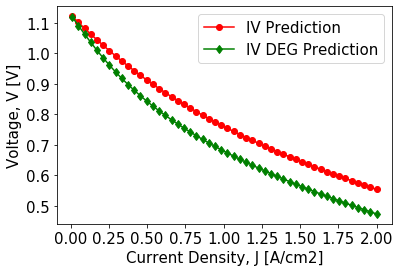

In [51]:
Jlist=np.linspace(0.01, 2, num=50)   #Current density, unit [A/cm2]
V_pred1 = np.zeros(50)
V_pred2 = np.zeros(50)

for j in range(50):
    V_pred1[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                      BV_alpha, BV_prexp, BV_Eact)  
    V_pred2[j], Voc, Ohmic, BV, Cath, Anode = IV_DEG(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                    cT, BV_alpha, BV_prexp, BV_Eact, 
                                                    SV1, SV2, SV3, SV4, SV5, SV6, SV7,
                                                    SV8, SV9, SV10, SV11, SV12, SV13, SV14)                        

plt.plot(Jlist, V_pred1, 'ro-', label = 'IV Prediction')
plt.plot(Jlist, V_pred2, 'gd-', label = 'IV DEG Prediction')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)

# Hist

In [ ]:
# For reference only: I-V relationship updated in 2017 by updating BV, Ohmic loss, Knudsen diffusion, etc. 
def SV(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,BV_alpha,BV_prexp,BV_Eact,
       SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14):
    # -- Initial Values placed here before integration with SOFC-MP
    # local SV_out = {numfields=1}
    # for k,v in pairs(sv_in) do
    #    SV_out.numfields = SV_out.numfields + 1
    #    SV_out[tostring(k)] = v
    # end
    # oT=SV_out["oT"]
    # fT=SV_out["fT"]
    # cT=SV_out["cT"]
    # J=SV_out["J"]
    # --nActiveCell=SV_out["nActiveCell"]
    # --DistanceFromTheEdge=SV_out["DistanceFromTheEdge"]
    # --DistanceFromTheEdgeRatio=SV_out["DistanceFromTheEdgeRatio"]
    # pH2=SV_out["pH2"]
    # pH2O=SV_out["pH2O"]
    # pCO=SV_out["pCO"]
    # pCO2=SV_out["pCO2"]
    # pCH4=SV_out["pCH4"]
    # pN2=SV_out["pN2"]
    # pO2air=SV_out["pO2air"]
    # pN2air=SV_out["pN2air"]
    # SV1=SV_out["SV1"]
    # SV2=SV_out["SV2"]
    # SV3=SV_out["SV3"]
    # SV4=SV_out["SV4"]
    # SV5=SV_out["SV5"]
    # SV6=SV_out["SV6"]
    # SV7=SV_out["SV7"]
    # SV8=SV_out["SV8"]
    # SV9=SV_out["SV9"]
    # SV10=SV_out["SV10"]
    # SV11=SV_out["SV11"]
    # SV12=SV_out["SV12"]
    # SV13=SV_out["SV13"]
    # SV14=SV_out["SV14"]
    #--
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- reasonble initial values
    # --SV1= 6.1e-7
    # --SV2= 4.75e-7
    # --SV3= 2.00e-6
    # --SV4= 7.00e+8
    # --SV5= 2.05
    # --SV6= 2.5
    # --SV7= 2.5
    # --SV8= 6.1e-7
    # --SV9= 4.75e-7
    # --SV10= 2.00e-6
    # --SV11= SV4
    # --SV12= 2.05
    # --SV13= 2.5
    # --SV14= 2.5
    
    # --Have direct impact
    # --SV3,5,7,10,12,14
    # --Do not have direct impact
    # --SV1,2,4,6,8,9,11,13
    
    #--issue: printflag=1 will cause an issue: no voltage value
    # printflag=0
    # if printflag==1 then
    # checkfile1=io.open("00checkSV1.txt","a")
    # checkfile1:write("In VOC.dat SV1 (d_eaa)= ",SV1,"\n")
    # checkfile1:write("In VOC.dat SV2 (d_iaa)= ",SV2,"\n")
    # --checkfile1:write("In VOC.dat SV3 (d_paa)= ",SV3,"\n")
    # --checkfile1:write("In VOC.dat SV4 (ltpba)= ",SV4,"\n")
    # --checkfile1:write("In VOC.dat SV5 (tortea)= ",SV5,"\n")
    # --checkfile1:write("In VOC.dat SV6 (tortia)= ",SV6,"\n")
    # --checkfile1:write("In VOC.dat SV7 (tortpa)= ",SV7,"\n")
    # --checkfile1:write("In VOC.dat SV8 (d_eac)= ",SV8,"\n")
    # --checkfile1:write("In VOC.dat SV9 (d_iac)= ",SV9,"\n")
    # --checkfile1:write("In VOC.dat SV10(d_pac)= ",SV10,"\n")
    # --checkfile1:write("In VOC.dat SV11(ltpbc)= ",SV11,"\n")
    # --checkfile1:write("In VOC.dat SV12(tortec)= ",SV12,"\n")
    # --checkfile1:write("In VOC.dat SV13(tortic)= ",SV13,"\n")
    # --checkfile1:write("In VOC.dat SV14(tortpc)= ",SV14,"\n")
    # --print(SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14)
    #   checkfile1:close()
    # end
    # --
    # -- Assign Flags
    BVflag=0     #   -- 0=old method, 1=pressurized method
    # --
    # -- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    # --tort_a=         2.5
    # --tort_c=         2.5
    tort_a=         SV7
    tort_c=         SV14
    
    # -- Additional microstructural properties added by JHM Dec 2016
    # -- th_aa 	um Anode active layer thickness
    # -- th_ca 	um Cathode active layer thickness
    # -- V_ic 	Vol % ionic conductor in cathode (active layer)
    # -- V_ia 	Vol % ionic conductor in anode (active layer)
    # -- V_eca 	Vol % electr conductor in cathode active layer
    # -- V_eaa	Vol % electr conductor in anode active layer
    # -- V_ec		Vol % of electronic conductor in cathode support
    # -- V_ea		Vol % of electronic conductor in anode support
    # -- tort_ae	Tort of electronic conducting phase in anode
    # -- tort_ce	Tort of electronic conducting phase in cathode
    # -- L_tpb_c	cm/cm**3 Triple phase boundary density in cathode
    # -- L_tpb_a	cm/cm**3 Triple phase boundary density in anode
    
    # -- Additional microstructural properties added by KPR Feb 2017
    # -- d_eaa	um diameter of electr cond particles in act anode
    # -- d_iaa	um diameter of ion cond particles in act anode
    # -- d_eac	um diameter of electr cond particles in act cathode
    # -- d_iac	um diameter of ion cond particles in act cathode
    th_aa =         30.0
    th_ca =         30.0
    if th_ca>th_c:
        th_ca = th_c

    V_ic =          26.0		#--See volfs in EvolutionSV()
    V_ia =          26.0
    V_eca =         100.0-por_c-V_ic
    V_eaa =         100.0-por_a-V_ia
    V_ec =          100.0-por_c
    V_ea =          100.0-por_a
    # --tort_ae =       2.05
    # --tort_ce =       1.21
    # --L_tpb_c =       7.0e8
    # --L_tpb_a =       7.0e8
    L_tpb_cz=       7.0e8
    L_tpb_az=       7.0e8
    tort_ae =       SV5
    tort_ce =       SV12
    L_tpb_c =       SV11		#--Uses SV8, SV9 (via SV1, SV2)
    L_tpb_a =       SV4		#--Uses SV1, SV2
    L_tpb_mean = 2.0/(1.0/L_tpb_c + 1.0/L_tpb_a)
    L_tpbz_mean = 2.0/(1.0/L_tpb_cz + 1.0/L_tpb_az)  #--KPR BV0 fix. Apr5,2017
    #print(L_tpb_a)
    
    # -- Additional microstructural properties added by JHM January 2017
    # -- tort_ai		Tortuosity of ionic conductor in active layer of anode
    # -- tort_ci		Tortuosity of ionic conductor in active layer of cathode
    # -- r_pore_a		cm Average pore radius in anode
    # -- r_pore_c		cm Averyage pore radius in cathode
    # --tort_ai =       2.5
    # --tort_ci =       2.5
    tort_ai =       SV6
    tort_ci =       SV13
    #--r_pore_a =      1.0e-4      
    #--r_pore_c =      1.0e-4
    r_pore_a =      SV3/2.0*100.
    r_pore_c =      SV10/2.0*100.
    
#     BV_alpha=       0.43236/21.5#0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0*0.98
    R_cont=         0.0
    BV_alpha2a=     2.0
    BV_prexp2a=     465000.0
    BV_Eact2a=      125000.0
    BV_gamma2a=     0.5
    BV_alpha2f=     1.0
    BV_prexp2f=     75000000.0
    BV_Eact2f=      110000.0
    BV_gamma2f=     0.133
    V_loss=         0.0
    
    BV_mod1 =1 #3.8+J*1.3# additional term for matching the overpotential data in 08-31-20_F6_7umYSZ_2YDC1300_LSCF1005_800oC_1_3V.xlsx
   
    #-- Additional microstructural BV terms added by JHM Dec 2016
    #-- scaled to account for Triple Phase Boundary density
    BV_prexp_TPB = BV_prexp/(L_tpbz_mean)  #--KPR BV0 fix. Apr5,2017
    L_tpb_mean_original = 2.0/(1.0/L_tpb_cz + 1.0/L_tpb_az)
    BV_prexp_TPB = BV_prexp/(L_tpb_mean_original) # Jie...
    BV_prexp2a_TPB = BV_prexp2a/L_tpb_cz
    BV_prexp2f_TPB = BV_prexp2f/L_tpb_az
    
    #--
    #-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0*0.99
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    
    #-- Old: s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #----------- New JHM Dec 2016:
    s_c_act = (s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*V_eca/tort_ce*0.01
    s_c = (s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*V_ec/tort_c*0.01
    
    #-- Compute the anode conductivity
    s_aA=1000
    
    #-- Old: s_a=s_aA*(1.0-(0.018*por_a))
    #----------- New JHM Dec 2016:
    s_a_act = s_aA*V_eaa/tort_ae*0.01
    s_a = s_aA*V_ea/tort_a*0.01
    
    #-- Compute the effective cell resistivity
    #-- Updated by JHM January 2017
    Ra = (th_a-th_aa)/s_a + th_aa/s_a_act
    Rc = (th_c-th_ca)/s_c + th_ca/s_c_act
    Re = th_e/s_e
    Rint = th_ic/s_ic
    Ri = R_cont + (Ra + Rc + Re + Rint)*0.0001
    #-- Compute the total ohmic loss
    Ohmic=Ri*J*1.0 #times 0.8 to match 08-31-20_F6_7umYSZ_2YDC1300_LSCF1005_800oC_1_3V  cell2 380h
    #--
    #-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
    #    ---------- No TPB:
    #    -- i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
    #    ---------- With TPB JHM Dec 2016:
        i0 = BV_prexp_TPB*L_tpb_mean*math.exp(-BV_Eact/R/Tk)
       
        i0 = BV_prexp_TPB*L_tpb_mean*math.exp(-BV_Eact/R/Tk)
       # print(L_tpb_mean,i0)
        BV=BV_mod1*(R*Tk/BV_alpha/F)*math.log((J*0.1/2.0/i0)+math.sqrt((J*0.1/2.0/i0)**2+1))
        #BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1)) #original
    else:
     #  -- New method
    	# ---------- Without TPB considered
     #  -- ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
     #  -- ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
    	# ---------- With TPB considered JHM Dec 2016
        ioeff_f=BV_prexp2f_TPB*L_tpb_a*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a_TPB*L_tpb_c*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
    
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    # if printflag==1:
    # --print(BV_prexp2f_TPB, L_tpb_a, BV_Eact2f, pO2anode, BV_gamma2f)
    # --print(R, Tk, BV_alpha2f, J, ioeff_f, F, eta_f, eta_a)
    # --print(BV)
    # end  --end print
    # end
    # --
    # -- Compute the diffusion coefficients
    # ------------------------------------------------------------------
    # -- Make 0.0 species non-zero to make equations defined
    if pCO<=0:
        pCOc=1e-16
    else:
        pCOc=pCO

    if pCO2<=0: 
        pCO2c=1e-16
    else:
        pCO2c=pCO2

    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0
    H2Oii=18.0
    COii=28.0
    CO2ii=44.0
    N2ii=28.0
    O2ii=32.0
    CH4ii=16.0
    #-- Average molecular weight & alphas
    Mavea=H2_mf*H2ii+H2O_mf*H2Oii+CO_mf*COii+CO2_mf*CO2ii+N2_mf*N2ii+CH4_mf*CH4ii
    alH2=1-math.sqrt(H2ii/Mavea)
    alH2O=1-math.sqrt(H2Oii/Mavea)
    alCO=1-math.sqrt(COii/Mavea)
    alCO2=1-math.sqrt(CO2ii/Mavea)
    alN2=1-math.sqrt(N2ii/Mavea)
    alCH4=1-math.sqrt(CH4ii/Mavea)
    #-- get alphas for cathode side
    Ptotc=pO2air+pN2air
    pO2air_mf=pO2air/Ptotc
    pN2air_mf=pN2air/Ptotc
    Mavec=pO2air_mf*O2ii+pN2air_mf*N2ii
    alO2air=1-math.sqrt(O2ii/Mavea)
    alN2air=1-math.sqrt(N2ii/Mavea)
    #-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    
    #-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    
    #-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    
    #--checkfile1:write("In VOC.dat D_H2 = ",D_H2,"\n")
    #--
    #-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    #-- Old Model
    Deffc=0.01*por_c*O2N2/tort_c
    #--checkfile1:write("In VOC.dat DeffcOLD = ",Deffc,"\n")
    #-- New Model - Add Knudsen Diffusion and Pore Radius - JHM January 2016
    convf = 1.0e7
    #    -- Calculate Knudsen Diffusion
    Dk_O2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*O2ii))**0.5*r_pore_c
    #--    Deffc = 0.01*por_c/tort_c*(2.0/(1.0/O2N2+1.0/Dk_O2))
    Deffc = 0.01*por_c/tort_c*(1.0/(1.0/O2N2+1.0/Dk_O2))  #--remove factor of 2. KPR. Apr5,2017
    #--io.write("Deffc,1= ",Deffc,"\n")
    Deffc = 0.01*por_c/(tort_c**1)*(1.0/((1.0-alO2air*pO2air_mf)/O2N2+1.0/Dk_O2))
    #--io.write("Deffc,1= ",Deffc,"\n")
    #--checkfile1:write("In VOC.dat Dk_O2 = ",Dk_O2,"\n")
    #--checkfile1:write("In VOC.dat Deffc = ",Deffc,"\n")
    #--
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    # -- Compute the anode concentration polarization
    # ------------------------------------------------------------------
    # -- Old Model
    # --DeffH2_old=D_H2
    # --DeffH2O_old=0.01*H2O_UD*por_a/tort_a
    # --DeffCO_old=0.01*CO_UD*por_a/tort_a
    # --DeffCO2_old=0.01*CO2_UD*por_a/tort_a
    # -- New Model - Add Knudsen Diffusion and Pore Radius - JHM January 2016
    #     -- Calculate Knudsen Diffusion for each species
    Dk_H2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*H2ii))**0.5*r_pore_a
    Dk_H2O = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*H2Oii))**0.5*r_pore_a
    Dk_CO = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*COii))**0.5*r_pore_a
    Dk_CO2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*CO2ii))**0.5*r_pore_a
    # --    DeffH2 = 2.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a*Dk_H2))
    # --    DeffH2O = 0.01*por_a/tort_a*(2.0/(1.0/H2O_UD+1.0/Dk_H2O))
    # --    DeffCO = 0.01*por_a/tort_a*(2.0/(1.0/CO_UD+1.0/Dk_CO))
    # --    DeffCO2 = 0.01*por_a/tort_a*(2.0/(1.0/CO2_UD+1.0/Dk_CO2))
    # --    DeffH2 = 1.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a*Dk_H2))  --** Removed factor of 2 from Deff
    # --    DeffH2O = 0.01*por_a/tort_a*(1.0/(1.0/H2O_UD+1.0/Dk_H2O))  --** Removed factor of 2 from Deff
    # --    DeffCO = 0.01*por_a/tort_a*(1.0/(1.0/CO_UD+1.0/Dk_CO))  --** Removed factor of 2 from Deff
    # --    DeffCO2 = 0.01*por_a/tort_a*(1.0/(1.0/CO2_UD+1.0/Dk_CO2))  --** Removed factor of 2 from Deff
    # --print(DeffH2, DeffH2O, DeffCO, DeffCO2)
    # --
    DeffH2 = 1.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a**1*Dk_H2))
    DeffH2O = 0.01*por_a/tort_a**1*(1.0/((1.0-alH2O*H2O_mf)/H2O_UD+1.0/Dk_H2O))
    DeffCO = 0.01*por_a/tort_a**1*(1.0/((1.0-alCO*CO_mf)/CO_UD+1.0/Dk_CO))
    DeffCO2 = 0.01*por_a/tort_a**1*(1.0/((1.0-alCO2*CO2_mf)/CO2_UD+1.0/Dk_CO2))
    # --checkfile1:write("In VOC.dat Dk_H2 = ",Dk_H2,"\n")
    # --checkfile1:write("In VOC.dat Dk_H2O = ",Dk_H2O,"\n")
    # --checkfile1:write("In VOC.dat DeffH2 = ",DeffH2,"\n")
    # --checkfile1:write("In VOC.dat DeffH2O = ",DeffH2O,"\n")
    
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim+1e10):
        Z=1/0.00001
    else:
        Jcalc=J
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA1=OPa_A
        holdB1=OPa_B
        holdC1=OPa_C
        stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
        stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A

    #print(stabcheck,stabcheck2)
    
    if stabcheck>0 :
      if stabcheck2>0 :
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        holdA2=0
        holdB2=0
        holdC2=0
        goober=1
      else:
        DeffH2=0.01*H2_UD*por_a/tort_a
        DeffH2O=0.01*H2O_UD*por_a/tort_a
        DeffCO=0.01*CO_UD*por_a/tort_a
        DeffCO2=0.01*CO2_UD*por_a/tort_a
        alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
        blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
        clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
        dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA2=OPa_A
        holdB2=OPa_B
        holdC2=OPa_C
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        goober=2

    #--Store polarization values for post-processing - KPR, April 14, 2017
    SV15=BV
    SV16=Ohmic
    SV17=Cath+Anod
    #--
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss
    Z=V
    return (Z,Voc,Ohmic,BV,Cath,Anod)

In [ ]:
# addtional inputs for 2017-version IV relationship/SV
SV1 = de_a #particle size of e-conduct in active anode
SV2 = de_a*alpha_a #particle size of ion-conduct in active anode
SV3 = 2.00e-6 #active anode pore size (diameter, m)  in active anode
SV4 = 7.00e+8 #triple phase boundary length  in active anode
SV5 = 2.05 #SV5,6,7, the anode tortuosities for the 3 phases  in active anode
SV6 = 2.0
SV7 = 2.0
SV8 = 6.1e-7 #particle size of e-conduct in active cathode
SV9 = 4.75e-7 #particle size of ion-conduct in active cathode
SV10 = 2.00e-6
SV11 = 7.00e+8
SV12 = 2.05
SV13 = 2.0
SV14 = 2.0

In [ ]:
V_SV=np.zeros(10)
V_Old=np.zeros(10)
V_New=np.zeros(10)
Jlist=np.linspace(0.2, 2, num=10)             #Current density, unit [A/cm2]

for j in range(10):
    V_SV[j], Voc, Ohmic, BV, Cath, Anode = SV(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                              BV_alpha,BV_prexp,BV_Eact,
                                              SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14)
    V_Old[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                   BV_alpha,BV_prexp,BV_Eact, 
                                                   False,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    V_New[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                   BV_alpha,BV_prexp,BV_Eact,
                                                   True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    
X=Jlist
xname = 'Current Density, J [A/cm2]'
yname = 'Voltage, V [V]'

plt.figure(figsize=(17.5,6))
plt.plot(X, V_SV, '-o', label='SV')
plt.plot(X, V_Old, '-d', label='IV Old')
plt.plot(X, V_New, '-s', label='IV New')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname, fontsize = 15)
plt.title('Comparison between SV, IV, IV_new', fontsize = 15)

Text(0.5, 1.0, 'EXP. VS. IV_new')

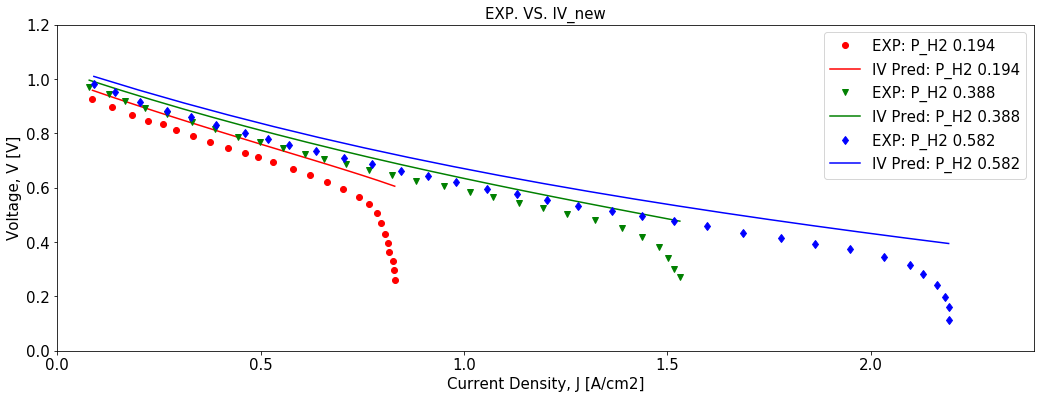

In [45]:
#comparison between L.Chick-2011 experimental data and IV_new predicitons

#initilize and optimize
param_guess = (0.43236, 5639, 79616, 0.0, 0.0, 0.1, 4.51e-4, 0.3) #BV_alpha, BV_prexp, BV_Eact, d0_c (d0_a)

def objective_function_LC(param_guess):  
    filename = './Resources_More/ExperimentalData/LC2011/AllData_LC.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    pH2 = data[:, 4]/100
    pH2O = data[:, 5]/100

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(Toper[j]+273.15,Toper[j]+273.15,x[j],pO2air,pN2air,
                                                           pH2[j],pH2O[j],0,0,0,1-pH2[j]-pH2O[j],pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4]) #, param_guess[5], param_guess[6],
#                                                          True,param_guess[7],param_guess[7])
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess)
result = minimize(objective_function_BP, param_guess) #, method = 'SLSQP')
# print(result)

# plot and comparison
Plist = [194, 388, 582]
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Plist)):
    oT_tmp = 750+273.15
    fT_tmp = oT_tmp
    pH2_tmp = Plist[i]/1000
    pH2O_tmp = 0.03
    pN2_tmp = 1-pH2_tmp-pH2O_tmp
    
    # plot exp data
    filename = './Resources_More/ExperimentalData/LC2011/750_'+str(Plist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP: P_H2 '+str(pH2_tmp))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_new_2(oT_tmp,fT_tmp,Jlist[j],pO2air,pN2air,pH2_tmp,pH2O_tmp,0,0,0,pN2_tmp,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4]) #, result.x[5], result.x[6])
#                                                        True,result.x[7],result.x[7])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred: P_H2 '+str(pH2_tmp))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlim(0, 2.4)
plt.ylim(0, 1.2)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

In [ ]:
def plot_allResults(fileName, nI, nV):
        '''
        This function loads the kriginginputFile, 
        infoFile and predictioninputFile
        '''
        namearray = []
        valuearray = []
        with open(fileName) as f:
            i = 0
            for line in f.readlines():
                if i == 0:
                    namearray = line.strip().split()
                else:
                    linestr = line.strip().split()
                    linenum = [float(lineele) for lineele in linestr]
                    valuearray.append(linenum)
                i += 1
               
        value = np.array(valuearray)
        I = value[:, nI]
        V = value[:, nV]
        ind = I.argsort()
        I_sorted = I[ind]
        V_sorted = V[ind]
        plt.plot(I_sorted, V_sorted, 'ro-',label = 'Simu (basic)')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(loc='upper right', fontsize=15)
        # ymin, ymax = plt.ylim()
        # plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
        plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
        plt.ylabel('Voltage, V [V]', fontsize = 15)

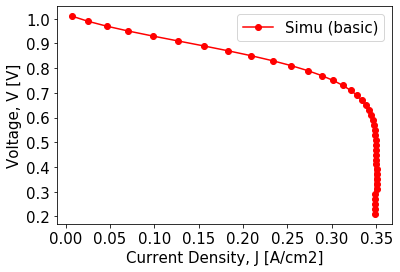

In [28]:
# basic case   
filename = './Resources_More/SimulationData/allResults_kriging.dat'    
plot_allResults(filename, 5, 3)

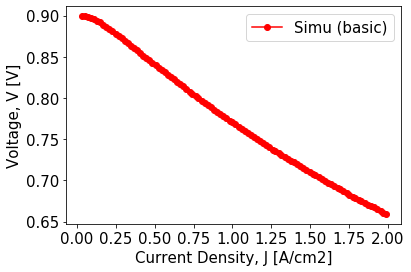

In [41]:
# NGFC ccs case
filename = './Resources_More/SimulationData/allResults_DNN.dat'    
plot_allResults(filename, 13, 11)